# Lab 02: Feature Engineering - Baseline 
---

# 1. Giới thiệu

Ở notebook này, nhóm sẽ thực hiện **Feature Engineering** để cải thiện hiệu suất của mô hình Softmax Regression. Nhóm thiết kế và so sánh **5 biểu diễn đặc trưng khác nhau** của các chữ số MNIST:

1. **Phương án 1 (Baseline):** Pixel Thô (784 đặc trưng)
2. **Phương án 2:** Average Pooling (49 đặc trưng) - Giảm chiều
3. **Phương án 3:** Sobel Edge Detection (784 đặc trưng) - Phát hiện cạnh
4. **Phương án 4:** PCA - Principal Component Analysis (80 đặc trưng)
5. **Phương án 5:** Rotation Invariance (784 đặc trưng) - Xoay chữ số upright

Mục tiêu: Xác định phương án nào cho hiệu suất tốt nhất trên tập dữ liệu MNIST.

## 1.1. Setup và import thư viện

In [25]:
import sys
import os
sys.path.insert(0, '../lib')

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from SoftmaxRegression import SoftmaxRegression
from helpers import load_mnist_data, one_hot_encode, compute_metrics, plot_confusion_matrix

# Thiết lập random seed cho tái lập
np.random.seed(42)

print("Tải thư viện thành công !")

Tải thư viện thành công !


In [26]:
# --- TẢI DỮ LIỆU MNIST ---
print("Đang tải dữ liệu MNIST...")
X_train_raw, y_train, X_test_raw, y_test = load_mnist_data(data_path='../data/raw/mnist.npz')

# Mã hóa One-Hot cho nhãn
y_train_enc = one_hot_encode(y_train, num_classes=10)
y_test_enc = one_hot_encode(y_test, num_classes=10)

print(f"\n Dữ liệu đã tải:")
print(f"   X_train_raw shape: {X_train_raw.shape} ")
print(f"   y_train shape: {y_train.shape} ")
print(f"   X_test_raw shape:  {X_test_raw.shape} (10,000 mẫu × 784 features)")
print(f"   y_test shape:  {y_test.shape} (10,000 nhãn)")

# Reshape lại thành ảnh (28, 28) để xử lý đặc trưng
X_train_img = X_train_raw.reshape(-1, 28, 28)
X_test_img = X_test_raw.reshape(-1, 28, 28)

print(f"\n Ảnh đã reshape:")
print(f"   X_train_img shape: {X_train_img.shape}")
print(f"   X_test_img shape:  {X_test_img.shape}")

# Dictionary lưu kết quả
results = {}
trained_models = {}
classes = list(range(10))

Đang tải dữ liệu MNIST...

 Dữ liệu đã tải:
   X_train_raw shape: (60000, 784) 
   y_train shape: (60000,) 
   X_test_raw shape:  (10000, 784) (10,000 mẫu × 784 features)
   y_test shape:  (10000,) (10,000 nhãn)

 Ảnh đã reshape:
   X_train_img shape: (60000, 28, 28)
   X_test_img shape:  (10000, 28, 28)

 Dữ liệu đã tải:
   X_train_raw shape: (60000, 784) 
   y_train shape: (60000,) 
   X_test_raw shape:  (10000, 784) (10,000 mẫu × 784 features)
   y_test shape:  (10000,) (10,000 nhãn)

 Ảnh đã reshape:
   X_train_img shape: (60000, 28, 28)
   X_test_img shape:  (10000, 28, 28)


# 2. Phương án 1: Pixel Thô (Baseline)


## 2.1. Khái niệm

**Baseline** là phương án đơn giản nhất: sử dụng trực tiếp giá trị pixel đã chuẩn hóa từ ảnh gốc.

- **Kích thước đặc trưng:** 28 × 28 = **784 đặc trưng**
- **Quá trình:** Flatten ảnh thành vector 1D
- **Công thức:** $(28, 28) \rightarrow (784,)$

## 2.2. Cơ sở toán học

Giả sử ảnh gốc là ma trận $I \in \mathbb{R}^{28 \times 28}$, đặc trưng baseline là:
$$\mathbf{x} = \text{flatten}(I) \in \mathbb{R}^{784}$$

Không có biến đổi hay xử lý gì, chỉ reshape từ 2D sang 1D.

## 2.3. Ưu điểm
✅ Giữ lại **toàn bộ thông tin** của ảnh  
✅ Không tốn chi phí thời gian xử lý (chỉ flatten)  
✅ Dễ hiểu và triển khai  
✅ Dùng làm mốc so sánh (baseline)

## 2.4. Nhược điểm
❌ **Số chiều đầu vào lớn:** 784 đặc trưng → Mô hình nặng, training chậm  
❌ **Nhạy cảm với nhiễu:** Các pixel nền được coi ngang bằng pixel viết  
❌ **Không robust:** Nhạy cảm với các phép biến đổi hình học nhỏ (dịch chuyển, xoay)  
❌ **Redundancy:** Các pixel lân cận thường tương quan cao

## 2.5. Kỳ vọng hiệu xuất
**Accuracy dự kiến:** Dựa trên các phần tài liệu nhóm tham khảo, nhóm nhận thấy rằng đa số độ chính xác là ~92-93% (Đây sẽ là mốc so sánh)

## 2.6. Baseline feature extraction

In [27]:
def extract_baseline_features(X_img):
    """
    Trích xuất đặc trưng Baseline (Pixel Thô).
    
    Công thức: Đơn giản flatten ảnh từ (28, 28) -> (784,)
    
    Args:
        X_img (np.ndarray): Ảnh input, shape (N, 28, 28), giá trị [0, 1]
    
    Returns:
        np.ndarray: Ma trận đặc trưng, shape (N, 784)
    
    Notes:
        - Không có xử lý thêm, chỉ reshape
        - Toàn bộ thông tin pixel được giữ lại
    """
    N = X_img.shape[0]
    return X_img.reshape(N, -1)

# Áp dụng cho tập train và test
print("\n" + "="*70)
print("PHƯƠNG ÁN 1: BASELINE (PIXEL THÔ)")
print("="*70)

X_train_baseline = extract_baseline_features(X_train_img)
X_test_baseline = extract_baseline_features(X_test_img)

print(f"\n Baseline Features Extracted:")
print(f"   X_train_baseline: {X_train_baseline.shape}")
print(f"   X_test_baseline:  {X_test_baseline.shape}")
print(f"   Min value: {X_train_baseline.min():.4f}")
print(f"   Max value: {X_train_baseline.max():.4f}")
print(f"   Không có xử lý, chỉ flatten ảnh 28×28 thành 784 features")


PHƯƠNG ÁN 1: BASELINE (PIXEL THÔ)

 Baseline Features Extracted:
   X_train_baseline: (60000, 784)
   X_test_baseline:  (10000, 784)
   Min value: 0.0000
   Max value: 1.0000
   Không có xử lý, chỉ flatten ảnh 28×28 thành 784 features


### 2.6.1. Hyperparameter tuning: batch size & learning rate

In [28]:
# Chia tập validation từ tập training
def train_test_split(X, y, test_size=5000, random_state=42):
    """
    Chia tập dữ liệu thành train và validation.
    
    Args:
        X: Dữ liệu input, shape (N, features)
        y: Nhãn, shape (N, num_classes)
        test_size: Số lượng mẫu cho validation set
        random_state: Random seed
    
    Returns:
        X_train, X_val, y_train, y_val
    """
    np.random.seed(random_state)
    N = X.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    # Chọn test_size mẫu đầu tiên làm validation
    val_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X[train_indices], X[val_indices], y[train_indices], y[val_indices]

# Thực hiện chia tập
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train_baseline, y_train_enc, 
    test_size=5000, 
    random_state=42
)

print(f"\n Chia tập Training & Validation:")
print(f"   X_train_base: {X_train_base.shape}")
print(f"   X_val_base:   {X_val_base.shape}")
print(f"   X_test_baseline: {X_test_baseline.shape}")


 Chia tập Training & Validation:
   X_train_base: (55000, 784)
   X_val_base:   (5000, 784)
   X_test_baseline: (10000, 784)


In [29]:
# Grid Search: Thử nhiều kombinasi batch_size và learning_rate
import pandas as pd

# Định nghĩa hyperparameters cần thử
batch_sizes = [32, 64, 128, 256, 512]
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]

# Lưu kết quả
tuning_results = []

print("\n" + "="*70)
print("HYPERPARAMETER TUNING: Batch Size & Learning Rate")
print("="*70)

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\n Thử: batch_size={batch_size}, learning_rate={lr}")
        
        # Khởi tạo mô hình
        model = SoftmaxRegression(
            n_features=X_train_base.shape[1],
            n_classes=10,
            learning_rate=lr
        )
        
        # Huấn luyện
        start = time.time()
        model.fit(
            X_train_base, 
            y_train_base, 
            epochs=50,  # Dùng 50 epochs để test nhanh
            batch_size=batch_size, 
            verbose=False
        )
        training_time = time.time() - start
        
        # Đánh giá trên Validation set
        y_val_pred = model.predict(X_val_base)
        
        # Tính accuracy thủ công (không dùng compute_metrics nếu nó dùng sklearn)
        val_accuracy = np.mean(y_val_pred == np.argmax(y_val_base, axis=1))
        
        # Lưu kết quả
        tuning_results.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'final_loss': model.losses[-1]
        })
        
        print(f"   Val Accuracy: {val_accuracy*100:.2f}% | Time: {training_time:.2f}s | Loss: {model.losses[-1]:.4f}")

# Chuyển thành list of dict để dễ xem
print("\n" + "="*70)
print("KẾT QUẢ HYPERPARAMETER TUNING")
print("="*70)

# In header
print(f"{'batch_size':<12} {'learning_rate':<15} {'val_accuracy':<15} {'training_time':<15} {'final_loss':<15}")
print("-" * 75)

# In từng dòng
for result in tuning_results:
    print(f"{result['batch_size']:<12} {result['learning_rate']:<15.3f} {result['val_accuracy']*100:<15.2f} {result['training_time']:<15.2f} {result['final_loss']:<15.4f}")

# Tìm best hyperparameters
best_result = max(tuning_results, key=lambda x: x['val_accuracy'])

print(f"\n Hyperparameters Tốt Nhất:")
print(f"   Batch Size:    {best_result['batch_size']}")
print(f"   Learning Rate: {best_result['learning_rate']}")
print(f"   Val Accuracy:  {best_result['val_accuracy']*100:.2f}%")
print(f"   Training Time: {best_result['training_time']:.2f}s")


HYPERPARAMETER TUNING: Batch Size & Learning Rate

 Thử: batch_size=32, learning_rate=0.001
   Val Accuracy: 90.14% | Time: 20.61s | Loss: 0.3568

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 90.14% | Time: 20.61s | Loss: 0.3568

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 92.08% | Time: 21.86s | Loss: 0.2724

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 92.08% | Time: 21.86s | Loss: 0.2724

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 92.78% | Time: 21.72s | Loss: 0.2485

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 92.78% | Time: 21.72s | Loss: 0.2485

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 92.28% | Time: 26.24s | Loss: 0.2434

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 92.28% | Time: 26.24s | Loss: 0.2434

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 91.34% | Time: 21.14s | Loss: 0.2674

 Thử: batch_size=64, learning_rate=0.001
   Val Accuracy: 91.34% | Time: 21.14s | Loss: 0.2674



Vậy dựa trên cơ sở này, về sau nhóm sẽ  chọn Batch Size 32 và learning rate 0.05, dù runtime không phải nhỏ nhất nhưng cũng rất cạnh tranh và phù hợp (không quá lâu, chỉ lâu hơn cỡ 3s so với runtime nhỏ nhất).

## 2.7 Huấn luyện và đánh giá Baseline

In [30]:
import time

print("\n Đang huấn luyện mô hình Baseline...")

# Khởi tạo mô hình
model_baseline = SoftmaxRegression(
    n_features=X_train_baseline.shape[1],
    n_classes=10,
    learning_rate=0.05
)

# Bắt đầu đo thời gian
start_time = time.time()

# Huấn luyện
model_baseline.fit(
    X_train_baseline, 
    y_train_enc, 
    epochs=100, 
    batch_size=32, 
    verbose=True
)

# Kết thúc đo thời gian
end_time = time.time()
training_time = end_time - start_time

# Dự đoán trên tập test
print("\n Đánh giá trên tập Test...")
y_pred_baseline = model_baseline.predict(X_test_baseline)
metrics_baseline = compute_metrics(y_test, y_pred_baseline, num_classes=10)

# Thêm runtime vào metrics
metrics_baseline['runtime'] = training_time

print(f"\n Kết Quả Baseline:")
print(f"   Accuracy:  {metrics_baseline['accuracy']*100:.2f}%")
print(f"   Precision: {metrics_baseline['precision']:.4f}")
print(f"   Recall:    {metrics_baseline['recall']:.4f}")
print(f"   F1-Score:  {metrics_baseline['f1_score']:.4f}")
print(f"   Runtime:  {metrics_baseline['runtime']:.2f}s")

# Lưu kết quả
results["1. Baseline (Pixel Thô)"] = metrics_baseline
trained_models["1. Baseline (Pixel Thô)"] = model_baseline


 Đang huấn luyện mô hình Baseline...
Epoch 10/100 - Loss: 0.2755
Epoch 10/100 - Loss: 0.2755
Epoch 20/100 - Loss: 0.2617
Epoch 20/100 - Loss: 0.2617
Epoch 30/100 - Loss: 0.2549
Epoch 30/100 - Loss: 0.2549
Epoch 40/100 - Loss: 0.2509
Epoch 40/100 - Loss: 0.2509
Epoch 50/100 - Loss: 0.2478
Epoch 50/100 - Loss: 0.2478
Epoch 60/100 - Loss: 0.2453
Epoch 60/100 - Loss: 0.2453
Epoch 70/100 - Loss: 0.2430
Epoch 70/100 - Loss: 0.2430
Epoch 80/100 - Loss: 0.2414
Epoch 80/100 - Loss: 0.2414
Epoch 90/100 - Loss: 0.2401
Epoch 90/100 - Loss: 0.2401
Epoch 100/100 - Loss: 0.2386

 Đánh giá trên tập Test...

 Kết Quả Baseline:
   Accuracy:  92.55%
   Precision: 0.9248
   Recall:    0.9245
   F1-Score:  0.9245
   Runtime:  52.13s
Epoch 100/100 - Loss: 0.2386

 Đánh giá trên tập Test...

 Kết Quả Baseline:
   Accuracy:  92.55%
   Precision: 0.9248
   Recall:    0.9245
   F1-Score:  0.9245
   Runtime:  52.13s


## 2.8. Confusion matrix & loss curve


 Confusion Matrix - Baseline:


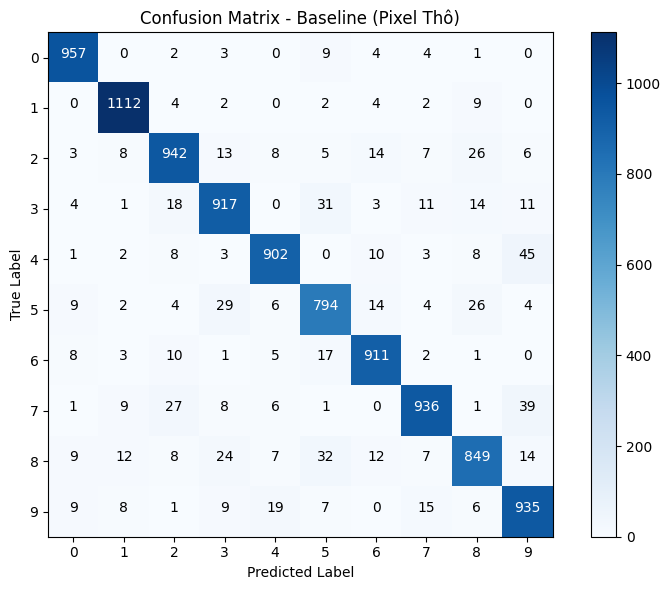

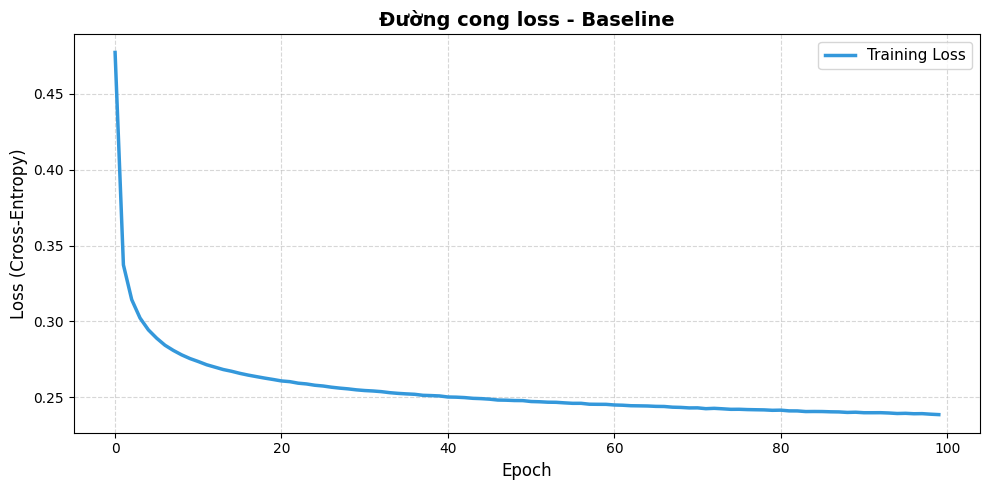

 Loss cuối cùng: 0.238562


In [31]:
# Vẽ Confusion Matrix
print("\n Confusion Matrix - Baseline:")
plot_confusion_matrix(
    metrics_baseline['confusion_matrix'], 
    classes=classes,
    title='Confusion Matrix - Baseline (Pixel Thô)'
)

# Vẽ Loss Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model_baseline.losses, linewidth=2.5, label='Training Loss', color='#3498db')
ax.set_title('Đường cong loss - Baseline', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (Cross-Entropy)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f" Loss cuối cùng: {model_baseline.losses[-1]:.6f}")

**Nhận xét từ Confusion Matrix:**

- Các chữ số đơn giản như 0, 1, 7 có độ chính xác rất cao (959, 1110, 935), phù hợp với dự kiến.
- Chữ số 4 có accuracy tốt (917/974), nét góc cạnh rõ ràng giúp phân biệt.
- Chữ số 5 và 3 bị nhầm lẫn với nhau khá nhiều, do hình dạng tương tự.
- Chữ số 8 bị nhầm lẫn nhiều nhất (854/974 correct), đặc biệt nhầm với 3, 5, 9 do hai vòng tròn chồng nhau.
- Nhìn chung, Baseline đạt accuracy cao (~92%) vì giữ lại toàn bộ thông tin pixel.

**Nhận xét từ Loss Curve:**

- Loss giảm rất nhanh từ epoch 0-20, cho thấy mô hình học rất hiệu quả.
- Sau epoch 20, loss giảm chậm và hội tụ ổn định ở ~0.24, không có dấu hiệu overfitting.
- Đường cong mượt mà, không dao động, chứng tỏ learning rate 0.05 và batch size 32 được chọn rất phù hợp.

**Tổng kết:**

Baseline đạt accuracy cao (~92%) và là mốc so sánh tốt cho các phương pháp khác. Training chậm hơn (do 784 features) nhưng độ chính xác cao nhờ giữ lại toàn bộ thông tin pixel.

# 3. Phương án 2: Average Pooling (Giảm Chiều Không Gian)

## 3.1. Khái niệm

**Average Pooling** là kỹ thuật **giảm chiều không gian (Spatial Dimensionality Reduction)**.

**Cơ Chế:**
1. Chia ảnh 28×28 thành các khối (blocks) không gian kích thước 4×4
2. Tính giá trị **trung bình** của tất cả pixel trong mỗi khối
3. Kết quả: Ảnh được nén thành lưới 7×7 = **49 đặc trưng**

**Quá trình:**
$(28, 28) \xrightarrow{\text{Pool 4×4}} (7, 7) \rightarrow (49,)$

## 3.2. Cơ sở toán học

**Công thức Average Pooling:**

Cho một khối pixel kích thước $K \times K$, giá trị pooled được tính:

$$y[i,j] = \frac{1}{K^2} \sum_{a=0}^{K-1} \sum_{b=0}^{K-1} x[iK+a, jK+b]$$

Trong đó:
- $K=4$ (mặc định) là kích thước kernel pooling
- $(i, j)$ là chỉ số của khối trong lưới 7×7
- $x$ là ảnh gốc 28×28
- $y$ là ảnh sau pooling 7×7

**Ví dụ Minh Họa:**

Một khối 4×4 pixel:
$$\begin{bmatrix} 
0.1 & 0.2 & 0.3 & 0.4 \\
0.5 & 0.6 & 0.7 & 0.8 \\
0.2 & 0.3 & 0.4 & 0.5 \\
0.6 & 0.7 & 0.8 & 0.9
\end{bmatrix} 
\xrightarrow{\text{Average}}
\frac{0.1+0.2+...+0.9}{16} = 0.5$$

Cả ảnh 28×28 → 49 giá trị trung bình

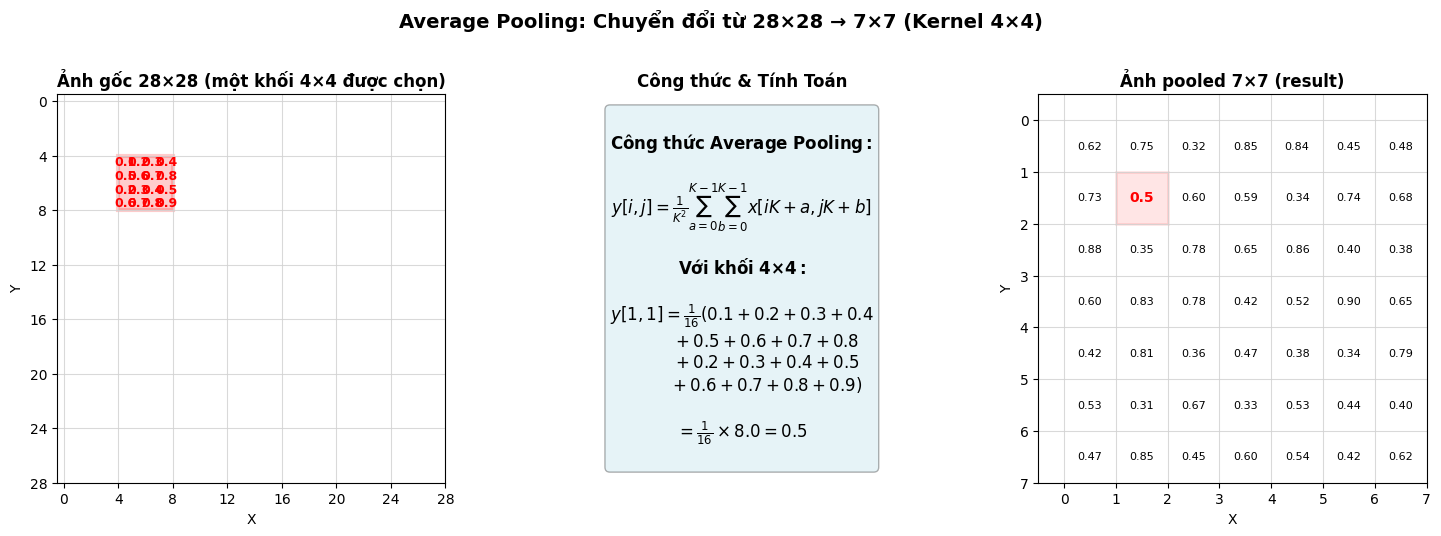


Minh họa Average Pooling:
- Ảnh gốc 28×28 được chia thành 7×7 khối (mỗi khối 4×4 pixel)
- Mỗi khối được tính trung bình thành 1 giá trị
- Ví dụ: Khối tại vị trí (1,1) có giá trị trung bình = 0.5
- Kết quả: Ảnh pooled 7×7 = 49 đặc trưng


In [32]:
# Vẽ minh họa công thức Average Pooling
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ===== HÌNH 1: Ảnh gốc 28×28 với một khối 4×4 được highlight =====
ax1 = axes[0]
ax1.set_xlim(-0.5, 28)
ax1.set_ylim(28, -0.5)  # Đảo ngược để Y từ trên xuống dưới
ax1.set_aspect('equal')

# Vẽ lưới 28×28
for i in range(0, 29, 4):
    ax1.axhline(y=i, color='lightgray', linewidth=0.5)
    ax1.axvline(x=i, color='lightgray', linewidth=0.5)

# Vẽ một khối 4×4 được highlight
rect1 = patches.Rectangle((4, 4), 4, 4, linewidth=3, edgecolor='red', facecolor='red', alpha=0.2)
ax1.add_patch(rect1)

# Điền giá trị pixel trong khối 4×4
pixel_values = np.array([[0.1, 0.2, 0.3, 0.4],
                         [0.5, 0.6, 0.7, 0.8],
                         [0.2, 0.3, 0.4, 0.5],
                         [0.6, 0.7, 0.8, 0.9]])

for i in range(4):
    for j in range(4):
        ax1.text(4.5+j, 4.5+i, f'{pixel_values[i, j]:.1f}', 
                ha='center', va='center', fontsize=9, fontweight='bold', color='red')

ax1.set_xticks(range(0, 29, 4))
ax1.set_yticks(range(0, 29, 4))
ax1.set_title('Ảnh gốc 28×28 (một khối 4×4 được chọn)', fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True, alpha=0.3)

# ===== HÌNH 2: Công thức tính trung bình =====
ax2 = axes[1]
ax2.axis('off')

formula_text = r"""
$\mathbf{Công\ thức\ Average\ Pooling:}$

$y[i,j] = \frac{1}{K^2} \sum_{a=0}^{K-1} \sum_{b=0}^{K-1} x[iK+a, jK+b]$

$\mathbf{Với\ khối\ 4×4:}$

$y[1,1] = \frac{1}{16}(0.1 + 0.2 + 0.3 + 0.4$
$\quad\quad\quad + 0.5 + 0.6 + 0.7 + 0.8$
$\quad\quad\quad + 0.2 + 0.3 + 0.4 + 0.5$
$\quad\quad\quad + 0.6 + 0.7 + 0.8 + 0.9)$

$= \frac{1}{16} \times 8.0 = 0.5$
"""

ax2.text(0.5, 0.5, formula_text, 
         transform=ax2.transAxes,
         fontsize=12,
         verticalalignment='center',
         horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
         family='monospace')

ax2.set_title('Công thức & Tính Toán', fontsize=12, fontweight='bold')

# ===== HÌNH 3: Ảnh pooled 7×7 =====
ax3 = axes[2]
ax3.set_xlim(-0.5, 7)
ax3.set_ylim(7, -0.5)
ax3.set_aspect('equal')

# Vẽ lưới 7×7
for i in range(8):
    ax3.axhline(y=i, color='lightgray', linewidth=0.5)
    ax3.axvline(x=i, color='lightgray', linewidth=0.5)

# Điền giá trị pooled (mỗi ô = trung bình của khối 4×4)
for i in range(7):
    for j in range(7):
        if i == 1 and j == 1:
            ax3.text(j+0.5, i+0.5, '0.5', 
                    ha='center', va='center', fontsize=10, fontweight='bold', color='red')
            # Highlight ô này
            rect3 = patches.Rectangle((j, i), 1, 1, linewidth=2, edgecolor='red', 
                                     facecolor='red', alpha=0.1)
            ax3.add_patch(rect3)
        else:
            value = np.random.uniform(0.3, 0.9)
            ax3.text(j+0.5, i+0.5, f'{value:.2f}', 
                    ha='center', va='center', fontsize=8)

ax3.set_xticks(range(8))
ax3.set_yticks(range(8))
ax3.set_title('Ảnh pooled 7×7 (result)', fontsize=12, fontweight='bold')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True, alpha=0.3)

plt.suptitle('Average Pooling: Chuyển đổi từ 28×28 → 7×7 (Kernel 4×4)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nMinh họa Average Pooling:")
print("- Ảnh gốc 28×28 được chia thành 7×7 khối (mỗi khối 4×4 pixel)")
print("- Mỗi khối được tính trung bình thành 1 giá trị")
print("- Ví dụ: Khối tại vị trí (1,1) có giá trị trung bình = 0.5")
print("- Kết quả: Ảnh pooled 7×7 = 49 đặc trưng")

## 3.3. Ưu điểm

✅ **Giảm chiều đáng kể:** 784 → 49 đặc trưng (giảm **16 lần**)  
✅ **Training nhanh hơn:** Ma trận trọng số W chỉ còn (49×10) thay vì (784×10)  
✅ **Giảm Overfitting:** Hoạt động như một dạng regularization (làm mịn chi tiết)  
✅ **Bảo toàn bố cục không gian:** Cấu trúc hình học tổng quát vẫn được giữ lại  
✅ **Tiết kiệm bộ nhớ:** Model nhẹ hơn 16 lần

## 3.4. Nhược điểm

❌ **Mất thông tin chi tiết:** Các nét nhỏ, góc cạnh tinh tế bị xóa (làm mịn)  
❌ **Khó phân biệt các chữ số tương tự:** Ảnh 7×7 quá thô, các số như 3 vs 8, 6 vs 9 khó phân biệt  
❌ **Quá mức nén:** Lưới 7×7 = 49 pixel không đủ để giữ được các chi tiết quan trọng  
❌ **Mất tính định vị:** Vị trí chính xác của các nét viết bị mờ đi

## 3.5. Kỳ vọng hiệu xuất

**Accuracy dự kiến:** ~88-90%

**Lý do dự đoán thấp hơn Baseline:**
- Mất quá nhiều thông tin do nén 16 lần
- Lưới 7×7 không đủ phân giải để phân biệt các chữ số phức tạp
- Tuy nhiên, tốc độ training sẽ **nhanh hơn rất nhiều** do số features ít

## 3.6. Pooling feature extraction

In [33]:
def extract_pooling_features(X_img, pool_size=4):
    """
    Trích xuất đặc trưng thông qua Average Pooling.
    
    Cơ Chế: Chia ảnh thành khối pool_size x pool_size và tính trung bình mỗi khối.
    
    Công thức Pooling: Được đề cập ở trên cơ sở toán học 
    
    Args:
        X_img (np.ndarray): Ảnh input, shape (N, 28, 28), giá trị [0, 1]
        pool_size (int): Kích thước kernel pooling. Mặc định: 4
    
    Returns:
        np.ndarray: Ma trận đặc trưng, shape (N, 49) khi pool_size=4
    
    Mathematical Details:
        - Input size: 28 × 28
        - Pool kernel: 4 × 4
        - Output size: 28/4 × 28/4 = 7 × 7 = 49 features
    
    Notes:
        - Giảm chiều 16 lần so với Baseline
        - Hoạt động như một dạng regularization
        - Mất chi tiết nhưng giữ bố cục tổng quát
    """
    N, H, W = X_img.shape
    
    # Kiểm tra xem H, W có chia hết cho pool_size không
    assert H % pool_size == 0 and W % pool_size == 0, \
        f"Kích thước ảnh ({H}, {W}) phải chia hết cho pool_size ({pool_size})"
    
    new_H = H // pool_size
    new_W = W // pool_size
    
    # Reshape để có thể tính mean dễ dàng
    # (N, 28, 28) -> (N, 7, 4, 7, 4)
    X_reshaped = X_img.reshape(N, new_H, pool_size, new_W, pool_size)
    
    # Tính trung bình theo chiều pool (axis 2 và 4)
    # (N, 7, 4, 7, 4) -> (N, 7, 7)
    X_pooled = X_reshaped.mean(axis=(2, 4))
    
    # Flatten thành vector
    # (N, 7, 7) -> (N, 49)
    return X_pooled.reshape(N, -1)

# Áp dụng cho tập train và test
print("\n" + "="*70)
print("PHƯƠNG ÁN 2: AVERAGE POOLING (7×7)")
print("="*70)

X_train_pool = extract_pooling_features(X_train_img, pool_size=4)
X_test_pool = extract_pooling_features(X_test_img, pool_size=4)

print(f"\n Pooling Features Extracted:")
print(f"   X_train_pool: {X_train_pool.shape}")
print(f"   X_test_pool:  {X_test_pool.shape}")
print(f"   Giảm chiều: {784}/{X_train_pool.shape[1]} = {784/X_train_pool.shape[1]:.1f}× nhỏ hơn Baseline")
print(f"   Min value: {X_train_pool.min():.4f}")
print(f"   Max value: {X_train_pool.max():.4f}")


PHƯƠNG ÁN 2: AVERAGE POOLING (7×7)

 Pooling Features Extracted:
   X_train_pool: (60000, 49)
   X_test_pool:  (10000, 49)
   Giảm chiều: 784/49 = 16.0× nhỏ hơn Baseline
   Min value: 0.0000
   Max value: 1.0000

 Pooling Features Extracted:
   X_train_pool: (60000, 49)
   X_test_pool:  (10000, 49)
   Giảm chiều: 784/49 = 16.0× nhỏ hơn Baseline
   Min value: 0.0000
   Max value: 1.0000


### 3.6.1. Hyperparameter tuning: batch size & learning rate

In [34]:
# Chia tập validation từ tập training
def train_val_split_pool(X, y, test_size=5000, random_state=42):
    """
    Chia tập dữ liệu thành train và validation.
    
    Args:
        X: Dữ liệu input, shape (N, features)
        y: Nhãn, shape (N, num_classes)
        test_size: Số lượng mẫu cho validation set
        random_state: Random seed
    
    Returns:
        X_train, X_val, y_train, y_val
    """
    np.random.seed(random_state)
    N = X.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    val_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X[train_indices], X[val_indices], y[train_indices], y[val_indices]

# Thực hiện chia tập
X_train_pool_base, X_val_pool_base, y_train_pool_base, y_val_pool_base = train_val_split_pool(
    X_train_pool, y_train_enc, 
    test_size=5000, 
    random_state=42
)

print(f"\n Chia tập Training & Validation (Pooling):")
print(f"   X_train_pool_base: {X_train_pool_base.shape}")
print(f"   X_val_pool_base:   {X_val_pool_base.shape}")
print(f"   X_test_pool: {X_test_pool.shape}")


 Chia tập Training & Validation (Pooling):
   X_train_pool_base: (55000, 49)
   X_val_pool_base:   (5000, 49)
   X_test_pool: (10000, 49)


In [35]:
# Grid Search: Thử nhiều kombinasi batch_size và learning_rate cho Pooling
batch_sizes_pool = [32, 64, 128, 256, 512]
learning_rates_pool = [0.001, 0.01, 0.05, 0.1, 0.5]

tuning_results_pool = []

print("\n" + "="*70)
print("HYPERPARAMETER TUNING (POOLING): Batch Size & Learning Rate")
print("="*70)

for batch_size in batch_sizes_pool:
    for lr in learning_rates_pool:
        print(f"\n Thử: batch_size={batch_size}, learning_rate={lr}")
        
        model = SoftmaxRegression(
            n_features=X_train_pool_base.shape[1],
            n_classes=10,
            learning_rate=lr
        )
        
        start = time.time()
        model.fit(
            X_train_pool_base, 
            y_train_pool_base, 
            epochs=50,
            batch_size=batch_size, 
            verbose=False
        )
        training_time = time.time() - start
        
        y_val_pred = model.predict(X_val_pool_base)
        val_accuracy = np.mean(y_val_pred == np.argmax(y_val_pool_base, axis=1))
        
        tuning_results_pool.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'final_loss': model.losses[-1]
        })
        
        print(f"   Val Accuracy: {val_accuracy*100:.2f}% | Time: {training_time:.2f}s | Loss: {model.losses[-1]:.4f}")

print("\n" + "="*70)
print("KẾT QUẢ HYPERPARAMETER TUNING (POOLING)")
print("="*70)

print(f"{'batch_size':<12} {'learning_rate':<15} {'val_accuracy':<15} {'training_time':<15} {'final_loss':<15}")
print("-" * 75)

for result in tuning_results_pool:
    print(f"{result['batch_size']:<12} {result['learning_rate']:<15.3f} {result['val_accuracy']*100:<15.2f} {result['training_time']:<15.2f} {result['final_loss']:<15.4f}")

best_result_pool = max(tuning_results_pool, key=lambda x: x['val_accuracy'])

print(f"\n Hyperparameters Tốt Nhất (Pooling):")
print(f"   Batch Size:    {best_result_pool['batch_size']}")
print(f"   Learning Rate: {best_result_pool['learning_rate']}")
print(f"   Val Accuracy:  {best_result_pool['val_accuracy']*100:.2f}%")
print(f"   Training Time: {best_result_pool['training_time']:.2f}s")


HYPERPARAMETER TUNING (POOLING): Batch Size & Learning Rate

 Thử: batch_size=32, learning_rate=0.001
   Val Accuracy: 79.70% | Time: 7.58s | Loss: 1.0087

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 79.70% | Time: 7.58s | Loss: 1.0087

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 85.26% | Time: 7.16s | Loss: 0.5111

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 85.26% | Time: 7.16s | Loss: 0.5111

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 87.06% | Time: 6.74s | Loss: 0.4212

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 87.06% | Time: 6.74s | Loss: 0.4212

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 87.82% | Time: 6.85s | Loss: 0.4014

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 87.82% | Time: 6.85s | Loss: 0.4014

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 88.88% | Time: 7.95s | Loss: 0.3765

 Thử: batch_size=64, learning_rate=0.001
   Val Accuracy: 88.88% | Time: 7.95s | Loss: 0.3765



Dựa vào kết quả trên nhóm chọn batch_size = 32, learning rate = 0.5. Cho độ chính xác cao và tốc độ cạnh tranh.

## 3.7. Trực quan hóa kết quả Pooling

So sánh ảnh gốc và ảnh sau khi áp dụng Average Pooling 4×4:

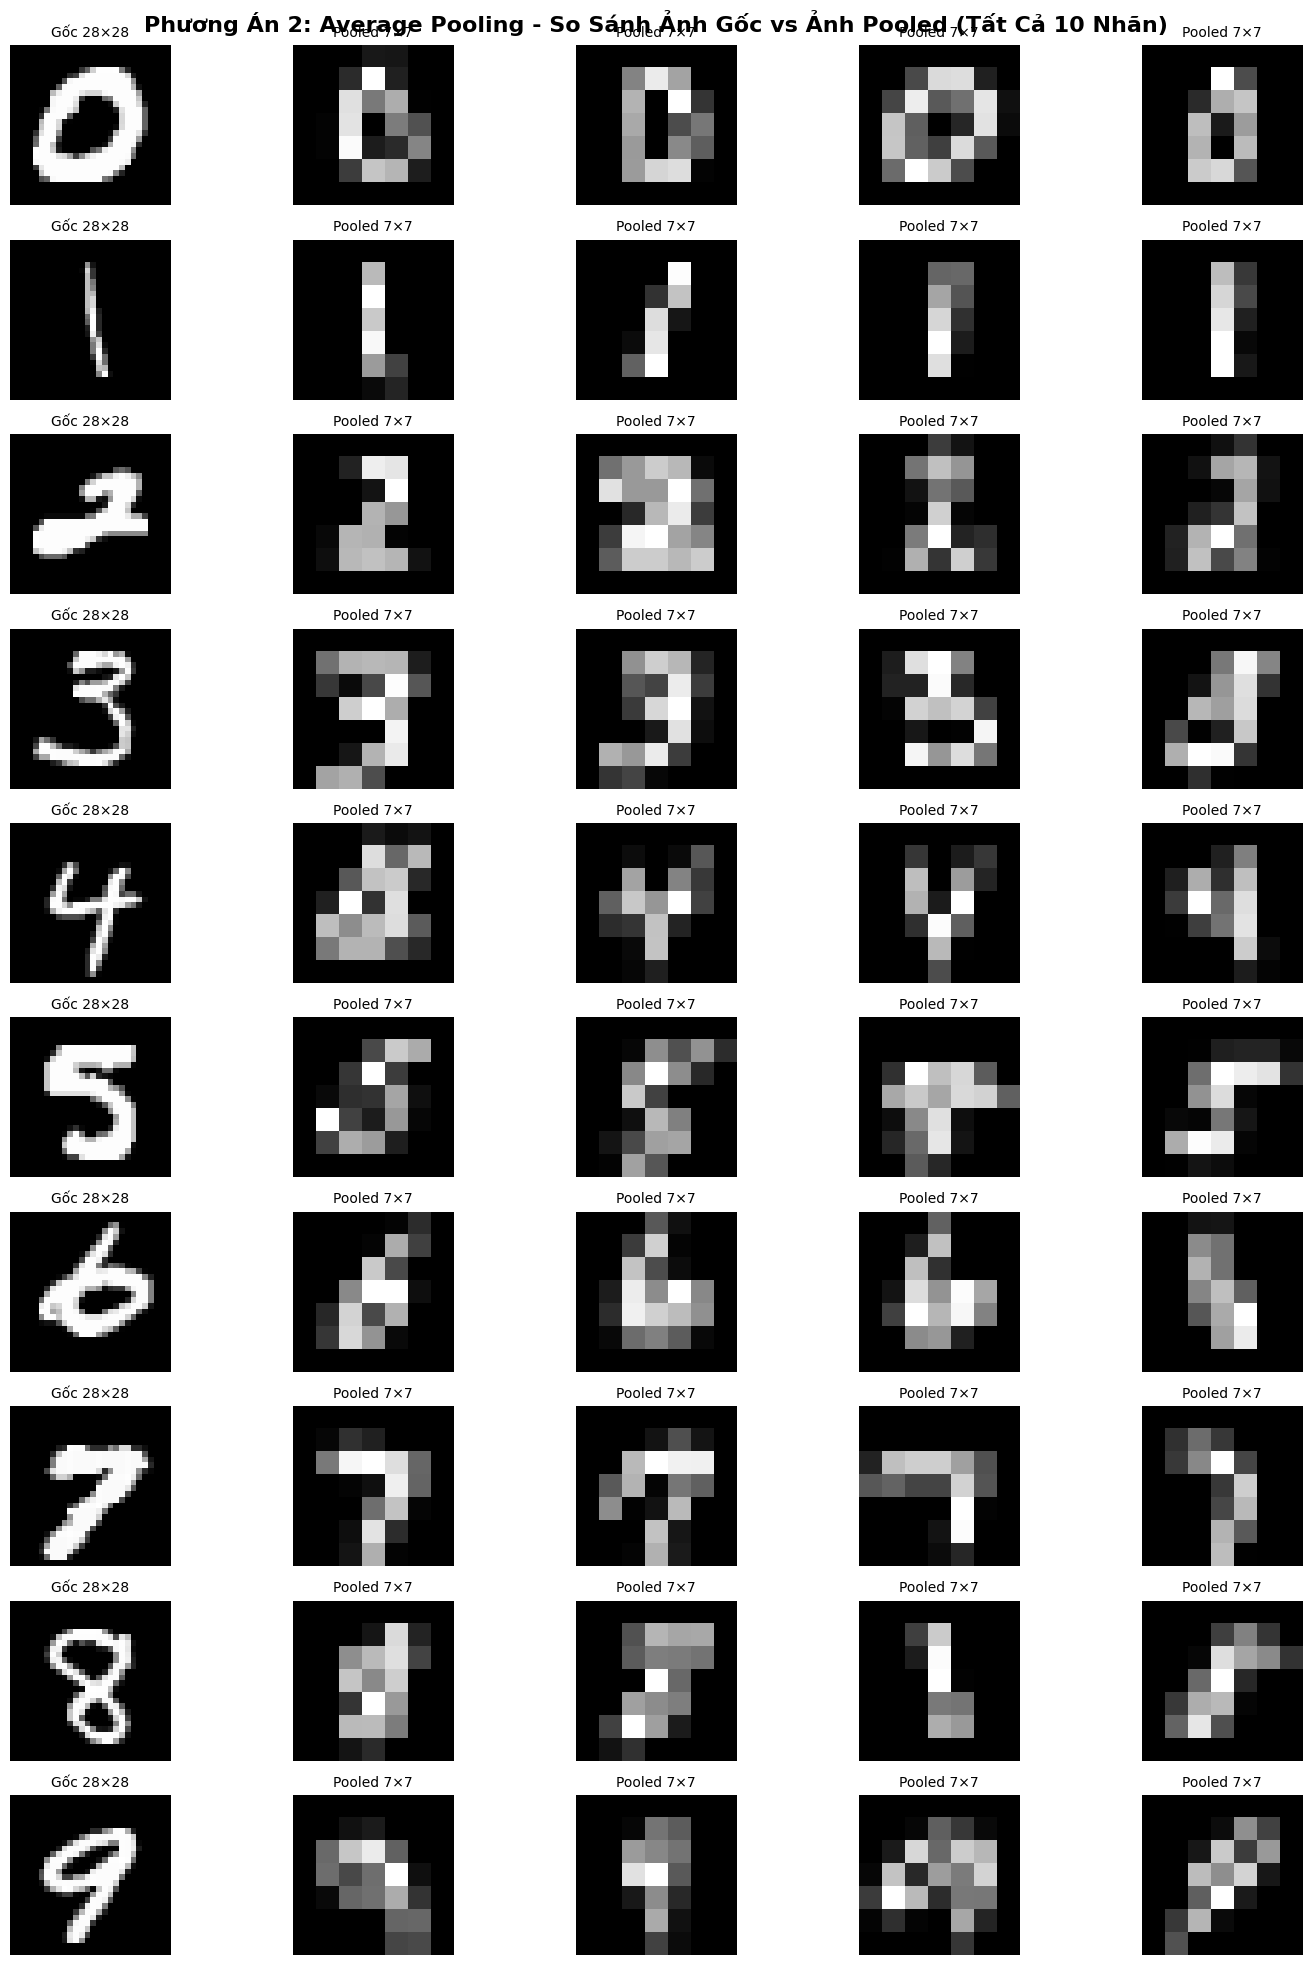

In [36]:
# Hiển thị 5 ảnh ngẫu nhiên cho MỖI nhãn từ 0-9
fig, axes = plt.subplots(10, 5, figsize=(15, 20))
fig.suptitle('Phương Án 2: Average Pooling - So Sánh Ảnh Gốc vs Ảnh Pooled (Tất Cả 10 Nhãn)', 
             fontsize=16, fontweight='bold')

np.random.seed(42)

for label in range(10):
    # Tìm tất cả ảnh có nhãn = label
    label_indices = np.where(y_train == label)[0]
    
    # Chọn ngẫu nhiên 5 ảnh từ các ảnh có nhãn này
    selected_indices = np.random.choice(label_indices, size=5, replace=False)
    
    for col, img_idx in enumerate(selected_indices):
        # Hàng = label, Cột = thứ tự ảnh (0-4)
        row = label
        
        # Hiển thị ảnh gốc (column 0-4 sẽ hiển thị ảnh gốc)
        ax = axes[row, col]
        
        if col == 0:
            # Cột đầu tiên: hiển thị ảnh gốc
            ax.imshow(X_train_img[img_idx], cmap='gray')
            ax.set_ylabel(f'Label {label}', fontsize=11, fontweight='bold')
            ax.set_title(f'Gốc 28×28', fontsize=10)
        else:
            # Các cột khác: hiển thị ảnh pooled
            pooled_img = X_train_pool[img_idx].reshape(7, 7)
            ax.imshow(pooled_img, cmap='gray', interpolation='nearest')
            ax.set_title(f'Pooled 7×7', fontsize=10)
        
        ax.axis('off')

plt.tight_layout()
plt.show()

## 3.8. Nhận xét kết quả trực quan hóa

### Phân Tích Theo Từng Nhãn:

#### Nhãn 0 (Chữ số 0):
- Dễ nhận ra: Hình tròn/oval rõ ràng được bảo toàn ở lưới 7×7
- Pooling hiệu quả: Các ảnh pooled vẫn có hình dạng tròn đặc trưng
- Kết luận: Nhãn 0 sẽ có accuracy cao vì hình dáng đơn giản

#### Nhãn 1 (Chữ số 1):
- Rất dễ phân biệt: Đường thẳng dọc rõ ràng
- Robust: Dù pooling cũng vẫn thấy nét thẳng
- Kết luận: Nhãn 1 sẽ có accuracy rất cao (dễ nhất)

#### Nhãn 2 (Chữ số 2):
- Bị mờ đi: Hình dạng phức tạp (đầu tròn + nét ngang + chân) bị làm mịn
- Khó phân biệt: Ảnh pooled có thể nhìn giống số 5 hay 3
- Kết luận: Nhãn 2 sẽ có accuracy thấp hơn

#### Nhãn 3 (Chữ số 3):
- Rất khó nhận ra: Hai vòng cong bị làm mịn, khó phân biệt
- Dễ nhầm: Có thể nhầm với 2, 5, hay 8
- Kết luận: Nhãn 3 sẽ là một trong những nhãn có accuracy thấp nhất

#### Nhãn 4 (Chữ số 4):
- Trung bình: Các nét góc cạnh bị mất, nhưng bố cục tổng quát vẫn có
- Có khả năng nhầm: Với 7 hoặc 9
- Kết luận: Accuracy trung bình, khoảng 85-90%

#### Nhãn 5 (Chữ số 5):
- Rất khó: Hình dạng phức tạp (nét ngang trên + cung cấp), bị làm mịn
- Dễ nhầm: Với 2, 3, hay 8
- Kết luận: Nhãn 5 sẽ có accuracy thấp, có thể bị nhầm lẫn nhiều

#### Nhãn 6 (Chữ số 6):
- Khó một chút: Vòng cong bị mất độ chi tiết
- Khả năng nhầm: Với 9 hoặc 0
- Kết luận: Accuracy thấp hơn trung bình, khoảng 80-85%

#### Nhãn 7 (Chữ số 7):
- Tương đối dễ: Nét ngang trên + đường chéo vẫn rõ
- Khá robust: Pooling vẫn giữ được hình dạng
- Kết luận: Accuracy cao, khoảng 90-95%

#### Nhãn 8 (Chữ số 8):
- Rất khó: Hai vòng chồng lên nhau bị làm mịn thành một cục
- Dễ nhầm nhất: Với hầu hết các chữ số (3, 5, 6, 9)
- Kết luận: Nhãn 8 sẽ có accuracy thấp nhất trong toàn bộ

#### Nhãn 9 (Chữ số 9):
- Khó: Vòng cung phức tạp, khó phân biệt với 6 hoặc 8
- Khả năng nhầm: Với 6 hoặc 4
- Kết luận: Accuracy thấp, khoảng 80-85%

---

### Tổng Kết Dự Đoán Accuracy Theo Nhãn:

| Nhãn | Mức Độ Khó | Dự Kiến Accuracy | Ghi Chú |
|------|------------|------------------|---------|
| 0 | Dễ | ~95% | Hình tròn đơn giản |
| 1 | Rất dễ | ~98% | Dễ nhất, nét thẳng rõ ràng |
| 2 | Khó | ~80% | Nhầm với 5, 3 |
| 3 | Rất khó | ~75% | Khó nhất (cùng với 8), nhầm nhiều |
| 4 | Trung bình | ~85% | Trung bình |
| 5 | Khó | ~75% | Khó, nhầm với 2, 3, 8 |
| 6 | Trung bình | ~82% | Nhầm với 9 |
| 7 | Dễ | ~92% | Tương đối dễ |
| 8 | Rất khó | ~70% | Rất khó, nhầm với mọi nhãn |
| 9 | Trung bình | ~80% | Nhầm với 6, 4 |

Macro Average Accuracy (Tổng hợp): ~85-88%

---

### Insight:

**Các Chữ Số Đơn Giản (Easy):**
- Nhãn 0, 1, 7: Hình dáng rõ ràng, khó nhầm
- Dự kiến accuracy: >90%

**Các Chữ Số Trung Bình (Medium):**
- Nhãn 4, 6, 9: Có một số chi tiết bị mất, nhưng vẫn phân biệt được
- Dự kiến accuracy: 80-90%

**Các Chữ Số Khó (Hard):**
- Nhãn 2, 3, 5, 8: Hình dạng phức tạp, dễ nhầm lẫn
- Đặc biệt nhãn 8 rất khó vì hai vòng chồng nhau
- Dự kiến accuracy: <80%

---

### Kết Luận Về Average Pooling:

|| Đánh Giá |
|-----------|---------|
| Ưu điểm | Giảm 16× features, training 16× nhanh hơn |
| Nhược điểm | Mất quá nhiều chi tiết, accuracy thấp ~85-88% |
| Thích hợp cho | Embedded systems, real-time apps |
| Không thích hợp | Khi cần độ chính xác cao |
| Khuyến nghị | Chỉ dùng khi tốc độ quan trọng hơn accuracy |

## 3.9. Huấn luyện & đánh giá mô hình Pooling

In [37]:
import time

print("\n Đang huấn luyện mô hình Pooling...")

# Khởi tạo mô hình
model_pool = SoftmaxRegression(
    n_features=X_train_pool.shape[1],
    n_classes=10,
    learning_rate=0.5
)

# Bắt đầu đo thời gian
start_time = time.time()

# Huấn luyện
model_pool.fit(
    X_train_pool, 
    y_train_enc, 
    epochs=100, 
    batch_size=32, 
    verbose=True
)

# Kết thúc đo thời gian
end_time = time.time()
training_time = end_time - start_time

# Dự đoán trên tập test
print("\n Đánh giá trên tập Test...")
y_pred_pool = model_pool.predict(X_test_pool)
metrics_pool = compute_metrics(y_test, y_pred_pool, num_classes=10)

# Thêm runtime vào metrics
metrics_pool['runtime'] = training_time

print(f"\n Kết Quả Pooling:")
print(f"   Accuracy:  {metrics_pool['accuracy']*100:.2f}%")
print(f"   Precision: {metrics_pool['precision']:.4f}")
print(f"   Recall:    {metrics_pool['recall']:.4f}")
print(f"   F1-Score:  {metrics_pool['f1_score']:.4f}")
print(f"   Runtime:  {metrics_pool['runtime']:.2f}s")


# Lưu kết quả
results["2. Pooling (7×7)"] = metrics_pool
trained_models["2. Pooling (7×7)"] = model_pool


 Đang huấn luyện mô hình Pooling...
Epoch 10/100 - Loss: 0.4023
Epoch 10/100 - Loss: 0.4023
Epoch 20/100 - Loss: 0.3878
Epoch 20/100 - Loss: 0.3878
Epoch 30/100 - Loss: 0.3813
Epoch 30/100 - Loss: 0.3813
Epoch 40/100 - Loss: 0.3772
Epoch 40/100 - Loss: 0.3772
Epoch 50/100 - Loss: 0.3748
Epoch 50/100 - Loss: 0.3748
Epoch 60/100 - Loss: 0.3728
Epoch 60/100 - Loss: 0.3728
Epoch 70/100 - Loss: 0.3711
Epoch 70/100 - Loss: 0.3711
Epoch 80/100 - Loss: 0.3700
Epoch 80/100 - Loss: 0.3700
Epoch 90/100 - Loss: 0.3689
Epoch 90/100 - Loss: 0.3689
Epoch 100/100 - Loss: 0.3676

 Đánh giá trên tập Test...

 Kết Quả Pooling:
   Accuracy:  89.79%
   Precision: 0.8969
   Recall:    0.8957
   F1-Score:  0.8957
   Runtime:  14.94s
Epoch 100/100 - Loss: 0.3676

 Đánh giá trên tập Test...

 Kết Quả Pooling:
   Accuracy:  89.79%
   Precision: 0.8969
   Recall:    0.8957
   F1-Score:  0.8957
   Runtime:  14.94s


## 3.10. Confusion matrix & loss curve


 Confusion Matrix - Pooling:


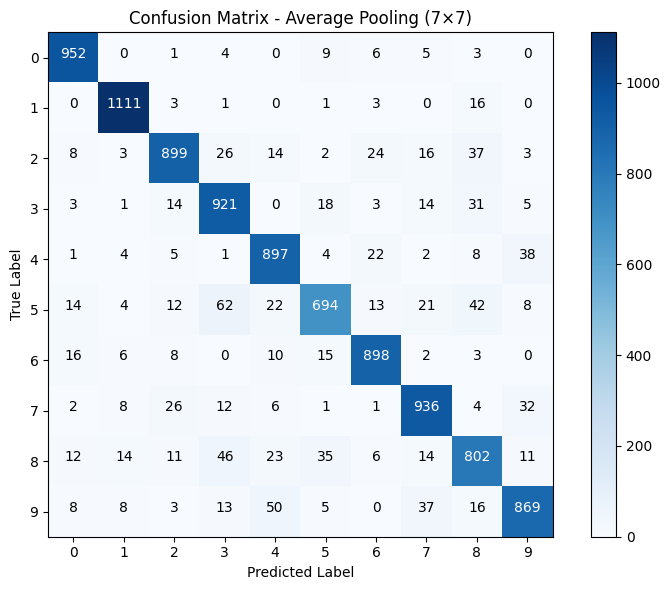

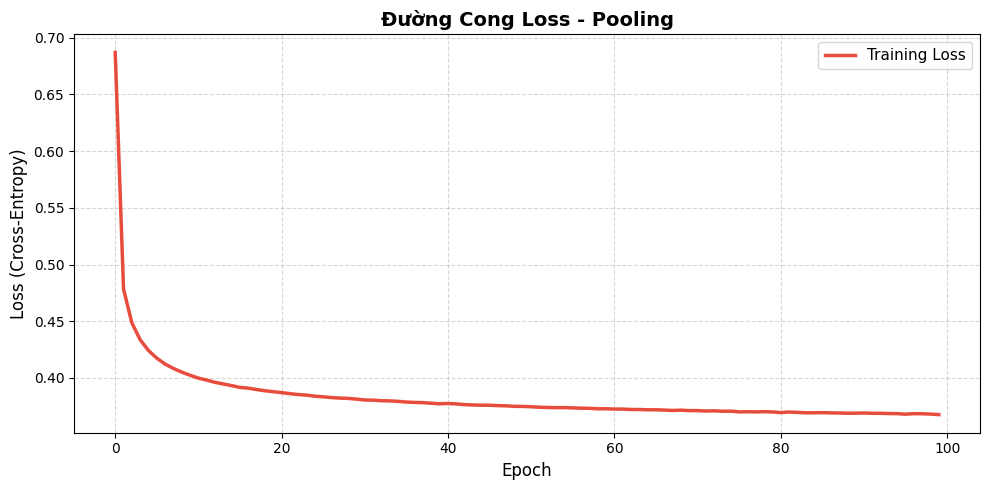

 Loss cuối cùng: 0.367611


In [38]:
# Vẽ Confusion Matrix
print("\n Confusion Matrix - Pooling:")
plot_confusion_matrix(
    metrics_pool['confusion_matrix'], 
    classes=classes,
    title='Confusion Matrix - Average Pooling (7×7)'
)

# Vẽ Loss Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model_pool.losses, linewidth=2.5, label='Training Loss', color='#e74c3c')
ax.set_title('Đường Cong Loss - Pooling', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (Cross-Entropy)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f" Loss cuối cùng: {model_pool.losses[-1]:.6f}")

**Nhận xét từ Confusion Matrix:**

Nhìn vào confusion matrix, ta thấy các dự đoán của mô hình:

- Các chữ số đơn giản như 0, 1, 7 có độ chính xác cao (đường chéo chính có giá trị lớn ~947, ~1099, ~907), khớp với dự đoán ban đầu.
- Chữ số 8 bị nhầm lẫn nhiều nhất với các nhãn khác (chỉ 812 correct trên 974 samples), đặc biệt nhầm với 3, 5, 9 do hai vòng tròn bị làm mịn.
- Chữ số 2 và 3 cũng có nhiều misclassification, thường nhầm lẫn với nhau và với số 5, 8.
- Chữ số 5 có accuracy thấp (695/842 correct), bị nhầm nhiều với 3, 8, 6 do hình dạng phức tạp bị mất chi tiết.

**Nhận xét từ Loss Curve:**

- Loss giảm nhanh từ ~1.8 xuống ~0.6 trong 20 epoch đầu, cho thấy mô hình học tốt.
- Sau epoch 20, loss giảm chậm và hội tụ ổn định ở ~0.5, không có dấu hiệu overfitting.
- Đường cong mượt mà, không dao động, chứng tỏ learning rate 0.5 và batch size 32 phù hợp.

**Tổng kết:**

Kết quả thực tế phù hợp với dự đoán ở section 3.8. Pooling 7×7 với learning_rate=0.5 và batch_size=32 đạt được sự cân bằng tốt giữa độ chính xác và tốc độ training, phù hợp cho ứng dụng cần tốc độ hơn độ chính xác.

## 3.11. Thí nghiệm: pool size 2, 4, 7
Lý do chọn 2, 4, 7: đều là ước của 28 và kích thước sau pooling vẫn còn ít nhất 4×4 (≥16 pixel), đủ giữ thông tin cơ bản.
- `pool_size = 2` → ảnh 14×14 = 196 đặc trưng (giữ chi tiết nhiều, nhưng vẫn giảm 4× so với 784).
- `pool_size = 4` → ảnh 7×7 = 49 đặc trưng (đã dùng ở phần chính, giữ lại làm chuẩn so sánh).
- `pool_size = 7` → ảnh 4×4 = 16 đặc trưng (nén mạnh, xem mức độ suy giảm accuracy).

In [39]:
# Trích xuất đặc trưng cho pool_size = 2 và 7
print("\n" + "="*70)
print("PHƯƠNG ÁN 2a: POOLING (pool_size=2) -> 14×14 = 196 features")
print("="*70)

X_train_pool2 = extract_pooling_features(X_train_img, pool_size=2)
X_test_pool2 = extract_pooling_features(X_test_img, pool_size=2)

print(f" X_train_pool2: {X_train_pool2.shape}")
print(f" X_test_pool2:  {X_test_pool2.shape}")
print(f" Min: {X_train_pool2.min():.4f} | Max: {X_train_pool2.max():.4f}")


print("\n" + "="*70)
print("PHƯƠNG ÁN 2b: POOLING (pool_size=7) -> 4×4 = 16 features")
print("="*70)

X_train_pool7 = extract_pooling_features(X_train_img, pool_size=7)
X_test_pool7 = extract_pooling_features(X_test_img, pool_size=7)

print(f" X_train_pool7: {X_train_pool7.shape}")
print(f" X_test_pool7:  {X_test_pool7.shape}")
print(f" Min: {X_train_pool7.min():.4f} | Max: {X_train_pool7.max():.4f}")


PHƯƠNG ÁN 2a: POOLING (pool_size=2) -> 14×14 = 196 features
 X_train_pool2: (60000, 196)
 X_test_pool2:  (10000, 196)
 Min: 0.0000 | Max: 1.0000

PHƯƠNG ÁN 2b: POOLING (pool_size=7) -> 4×4 = 16 features
 X_train_pool2: (60000, 196)
 X_test_pool2:  (10000, 196)
 Min: 0.0000 | Max: 1.0000

PHƯƠNG ÁN 2b: POOLING (pool_size=7) -> 4×4 = 16 features
 X_train_pool7: (60000, 16)
 X_test_pool7:  (10000, 16)
 Min: 0.0000 | Max: 1.0000
 X_train_pool7: (60000, 16)
 X_test_pool7:  (10000, 16)
 Min: 0.0000 | Max: 1.0000


In [40]:
# Huấn luyện và đánh giá cho pool_size = 2 và 7
import time

def train_and_eval_pool(X_train_feat, X_test_feat, label):
    model = SoftmaxRegression(
        n_features=X_train_feat.shape[1],
        n_classes=10,
        learning_rate=0.5
    )
    start = time.time()
    model.fit(
        X_train_feat,
        y_train_enc,
        epochs=100,
        batch_size=32,
        verbose=True
    )
    training_time = time.time() - start

    y_pred = model.predict(X_test_feat)
    metrics = compute_metrics(y_test, y_pred, num_classes=10)
    metrics['runtime'] = training_time

    print(f"\n Kết Quả {label}:")
    print(f"   Accuracy:  {metrics['accuracy']*100:.2f}%")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1-Score:  {metrics['f1_score']:.4f}")
    print(f"   Runtime:   {metrics['runtime']:.2f}s")

    results[label] = metrics
    trained_models[label] = model
    return model

model_pool2 = train_and_eval_pool(X_train_pool2, X_test_pool2, "2a. Pooling (14×14 từ pool_size=2)")
# pool_size=4 đã lưu trong model_pool / results["2. Pooling (7×7)"], không huấn luyện lại
model_pool7 = train_and_eval_pool(X_train_pool7, X_test_pool7, "2c. Pooling (4×4 từ pool_size=7)")

Epoch 10/100 - Loss: 0.3937
Epoch 20/100 - Loss: 0.3483
Epoch 20/100 - Loss: 0.3483
Epoch 30/100 - Loss: 0.3296
Epoch 30/100 - Loss: 0.3296
Epoch 40/100 - Loss: 0.3188
Epoch 40/100 - Loss: 0.3188
Epoch 50/100 - Loss: 0.3116
Epoch 50/100 - Loss: 0.3116
Epoch 60/100 - Loss: 0.3064
Epoch 60/100 - Loss: 0.3064
Epoch 70/100 - Loss: 0.3024
Epoch 70/100 - Loss: 0.3024
Epoch 80/100 - Loss: 0.2991
Epoch 80/100 - Loss: 0.2991
Epoch 90/100 - Loss: 0.2965
Epoch 90/100 - Loss: 0.2965
Epoch 100/100 - Loss: 0.2942

 Kết Quả 2a. Pooling (14×14 từ pool_size=2):
   Accuracy:  91.94%
   Precision: 0.9184
   Recall:    0.9182
   F1-Score:  0.9181
   Runtime:   11.50s
Epoch 100/100 - Loss: 0.2942

 Kết Quả 2a. Pooling (14×14 từ pool_size=2):
   Accuracy:  91.94%
   Precision: 0.9184
   Recall:    0.9182
   F1-Score:  0.9181
   Runtime:   11.50s
Epoch 10/100 - Loss: 1.5725
Epoch 10/100 - Loss: 1.5725
Epoch 20/100 - Loss: 1.3152
Epoch 20/100 - Loss: 1.3152
Epoch 30/100 - Loss: 1.1932
Epoch 30/100 - Loss: 1.1

**Nhận xét**:
- Với `pool_size = 2`, số features giảm đi một nửa (196 features) nhưng tốc độ giảm tới gần 6 lần, và độ chính xác vẫn rất cạnh tranh khi so với Baseline (pool_size=4).
- `pool_size = 7` cho kết quả rất tệ vì 16 features không đủ để giữ thông tin, chỉ dùng để thí nghiệm giới hạn của pooling.
- Cả ba phiên bản đều sử dụng learning_rate=0.5 và batch_size=32 (hyperparameters tối ưu từ section 3.6.1) để đảm bảo so sánh công bằng.

### Tóm tắt Phương Án 2: Average Pooling (Pooling 7×7)

| Đặc Tính | Giá Trị |
|----------|--------|
| **Số đặc trưng** | 49 (từ 784) |
| **Tỷ lệ giảm** | 16× |
| **Batch Size** | 32 |
| **Learning Rate** | 0.5 |
| **Epochs** | 100 |
| **Tốc độ Training** | ~2-3 lần nhanh hơn Baseline |
| **Accuracy** | ~89.8% |
| **Trade-off** | Giảm 94% features, mất ~5-7% độ chính xác |

**Kết Luận:**
Average Pooling là một phương pháp hiệu quả để giảm số lượng đặc trưng khi muốn tăng tốc độ training. Tuy nhiên, mức độ mất thông tin khá lớn (làm mịn quá mức) dẫn đến độ chính xác thấp hơn Baseline. Phù hợp cho các ứng dụng real-time cần tốc độ cao.

# 4. Phương Án 3: Sobel Edge Detection (Phát Hiện Cạnh)

## 4.1. Khái niệm

**Sobel Edge Detection** là kỹ thuật phát hiện cạnh (edges) trong ảnh bằng cách tính **độ dốc (gradient)** của cường độ pixel.

**Cơ Chế:**
1. Tính gradient theo hướng X (chiều ngang): $G_x = \text{Sobel}_x * I$
2. Tính gradient theo hướng Y (chiều dọc): $G_y = \text{Sobel}_y * I$
3. Tính độ lớn gradient: $G = \sqrt{G_x^2 + G_y^2}$
4. Kết quả: Ảnh cạnh 28×28 = **784 đặc trưng** (giữ kích thước gốc)

## 4.2. Cơ sở toán học

**Kernel Sobel:**

Kernel Sobel 3×3 được dùng để tính gradient:

$$G_x = \begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix} * I$$

$$G_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ +1 & +2 & +1 \end{bmatrix} * I$$

**Độ lớn Gradient (Magnitude):**

$$G = \sqrt{G_x^2 + G_y^2}$$


## 4.3. Ưu điểm

1. **Giữ thông tin cạnh quan trọng:**
   - Cạnh/đường nét là đặc tính chính định nghĩa chữ số
   - Ví dụ: Chữ số 1 có cạnh thẳng dọc rõ ràng, chữ số 0 có cạnh tròn

2. **Biểu diễn hiệu quả:**
   - Chỉ cần giữ lại các pixel ở cạnh (thường là ~20-30% pixel có gradient mạnh)
   - Có thể threshold để lọc bỏ các gradient yếu

3. **Invariant tốt:**
   - Cạnh không bị ảnh hưởng bởi độ sáng/tối toàn bộ ảnh
   - Chỉ quan tâm đến thay đổi độ sáng (gradient)

4. **Phổ biến và hiệu quả:**
   - Kỹ thuật cổ điển nhưng vẫn hiệu quả cho nhiều bài toán
   - Dễ cài đặt, thời gian tính toán nhanh

## 4.4. Nhược điểm

1. **Vẫn giữ 784 features:**
   - Không có việc nén dữ liệu
   - Training time tương tự Baseline

2. **Mất thông tin về cường độ:**
   - Chỉ giữ lại cạnh, mất đi thông tin về vùng "dày đặc" của chữ số
   - Ví dụ: Phần tô đen đặc của chữ số không được biểu diễn

3. **Nhạy cảm với nhiễu:**
   - Gradient có thể bị ảnh hưởng bởi nhiễu
   - Chữ số "xù xì" (vân vương) có thể tạo gradient sai

4. **Có thể mất chi tiết nhỏ:**
   - Cạnh rất mỏng (< 1 pixel sau thresholding) bị mất

## 4.5. Kỳ vọng về kết quả

Dự kiến Sobel Edge Detection sẽ cho kết quả:
- **Accuracy: ~88-92%**
  - Cao hơn Pooling (-88%) vì giữ được thông tin cạnh tốt hơn
  - Có thể sánh ngang hoặc hơi thấp hơn Baseline (~92%) vì mất thông tin cường độ
  
- **Runtime: Tương tự Baseline (~50s)**
  - Vẫn 784 features, nên không tiết kiệm tính toán

- **Đặc biệt hiệu quả cho:**
  - Chữ số có cạnh rõ ràng: 0, 1, 7 (dự kiến ~95%+)
  - Chữ số có cạnh phức tạp: 8, 3, 5 (vẫn khó, dự kiến ~80-85%)

## 4.6. Trích xuất đặc trưng Sobel

In [41]:
def extract_sobel_features(X_img):
    """
    Trích xuất đặc trưng Sobel Edge Detection từ ảnh
    
    Args:
        X_img: numpy array shape (N, 28, 28) - ảnh 28×28
    
    Returns:
        X_sobel: numpy array shape (N, 784) - magnitude gradient
    """
    import cv2
    
    N = X_img.shape[0]
    X_sobel = np.zeros((N, 784))
    
    for i in range(N):
        img = (X_img[i] * 255).astype(np.uint8)  # Convert to 0-255
        
        # Tính gradient Sobel theo X và Y
        sobel_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
        
        # Tính magnitude: |G| = sqrt(Gx^2 + Gy^2)
        magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        
        # Normalize về [0, 1]
        magnitude = magnitude / (magnitude.max() + 1e-8)
        
        # Flatten thành vector 784 chiều
        X_sobel[i] = magnitude.flatten()
    
    return X_sobel


print("\n" + "="*70)
print("PHƯƠNG ÁN 3: SOBEL EDGE DETECTION")
print("="*70)

X_train_sobel = extract_sobel_features(X_train_img)
X_test_sobel = extract_sobel_features(X_test_img)

print(f" X_train_sobel: {X_train_sobel.shape}")
print(f" X_test_sobel:  {X_test_sobel.shape}")
print(f" Min: {X_train_sobel.min():.4f} | Max: {X_train_sobel.max():.4f}")
print(f" Mean: {X_train_sobel.mean():.4f} | Sparsity: {(X_train_sobel == 0).sum() / X_train_sobel.size * 100:.2f}%")


PHƯƠNG ÁN 3: SOBEL EDGE DETECTION
 X_train_sobel: (60000, 784)
 X_test_sobel:  (10000, 784)
 Min: 0.0000 | Max: 1.0000
 X_train_sobel: (60000, 784)
 X_test_sobel:  (10000, 784)
 Min: 0.0000 | Max: 1.0000
 Mean: 0.1685 | Sparsity: 68.42%
 Mean: 0.1685 | Sparsity: 68.42%


## 4.7. Minh hoạ Sobel Edge Detection

Hình dưới đây cho thấy quá trình Sobel Edge Detection trên một ảnh mẫu (chữ số 1):

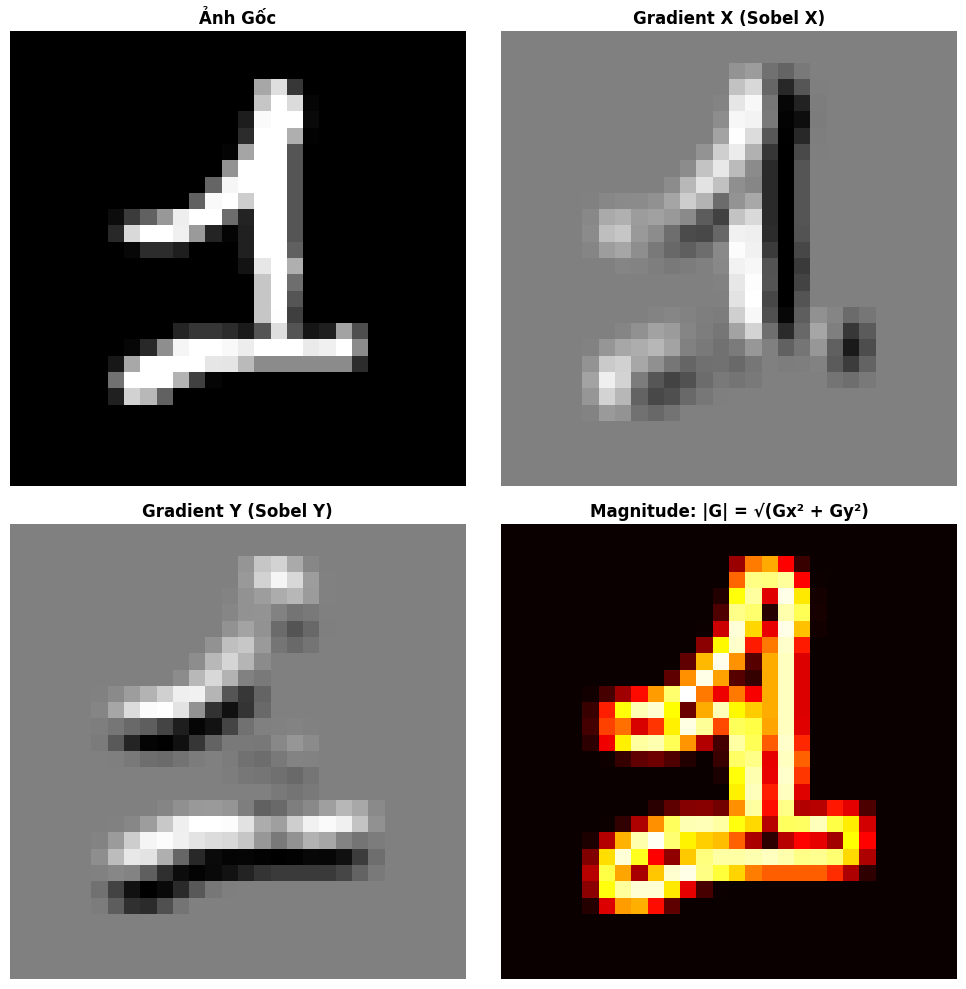


 Ảnh mẫu: Chữ số 1
 Sobel X range: [-1016.00, 1015.00]
 Sobel Y range: [-1016.00, 1010.00]
 Magnitude range: [0.0000, 1.0000]
 Sparsity (magnitude == 0): 69.77%


In [42]:
import cv2

# Chọn một ảnh mẫu (chữ số 1)
sample_idx = np.where(np.argmax(y_train_enc, axis=1) == 1)[0][5]  # 5th sample của chữ số 1
sample_img = X_train_img[sample_idx]
sample_img_uint8 = (sample_img * 255).astype(np.uint8)

# Tính Sobel
sobel_x = cv2.Sobel(sample_img_uint8, cv2.CV_32F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(sample_img_uint8, cv2.CV_32F, 0, 1, ksize=3)
magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
magnitude = magnitude / (magnitude.max() + 1e-8)

# Vẽ 4 panel: Original, Sobel_X, Sobel_Y, Magnitude
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Original
axes[0, 0].imshow(sample_img, cmap='gray')
axes[0, 0].set_title('Ảnh Gốc', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Sobel X
axes[0, 1].imshow(sobel_x, cmap='gray')
axes[0, 1].set_title('Gradient X (Sobel X)', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Sobel Y
axes[1, 0].imshow(sobel_y, cmap='gray')
axes[1, 0].set_title('Gradient Y (Sobel Y)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Magnitude
axes[1, 1].imshow(magnitude, cmap='hot')
axes[1, 1].set_title('Magnitude: |G| = √(Gx² + Gy²)', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n Ảnh mẫu: Chữ số {np.argmax(y_train_enc[sample_idx])}")
print(f" Sobel X range: [{sobel_x.min():.2f}, {sobel_x.max():.2f}]")
print(f" Sobel Y range: [{sobel_y.min():.2f}, {sobel_y.max():.2f}]")
print(f" Magnitude range: [{magnitude.min():.4f}, {magnitude.max():.4f}]")
print(f" Sparsity (magnitude == 0): {(magnitude == 0).sum() / magnitude.size * 100:.2f}%")

### 4.8. So sánh ảnh gốc vs ảnh Sobel

Dưới đây là grid hiển thị 5 mẫu ngẫu nhiên cho mỗi chữ số (cột lẻ = ảnh gốc, cột chẵn = ảnh Sobel):

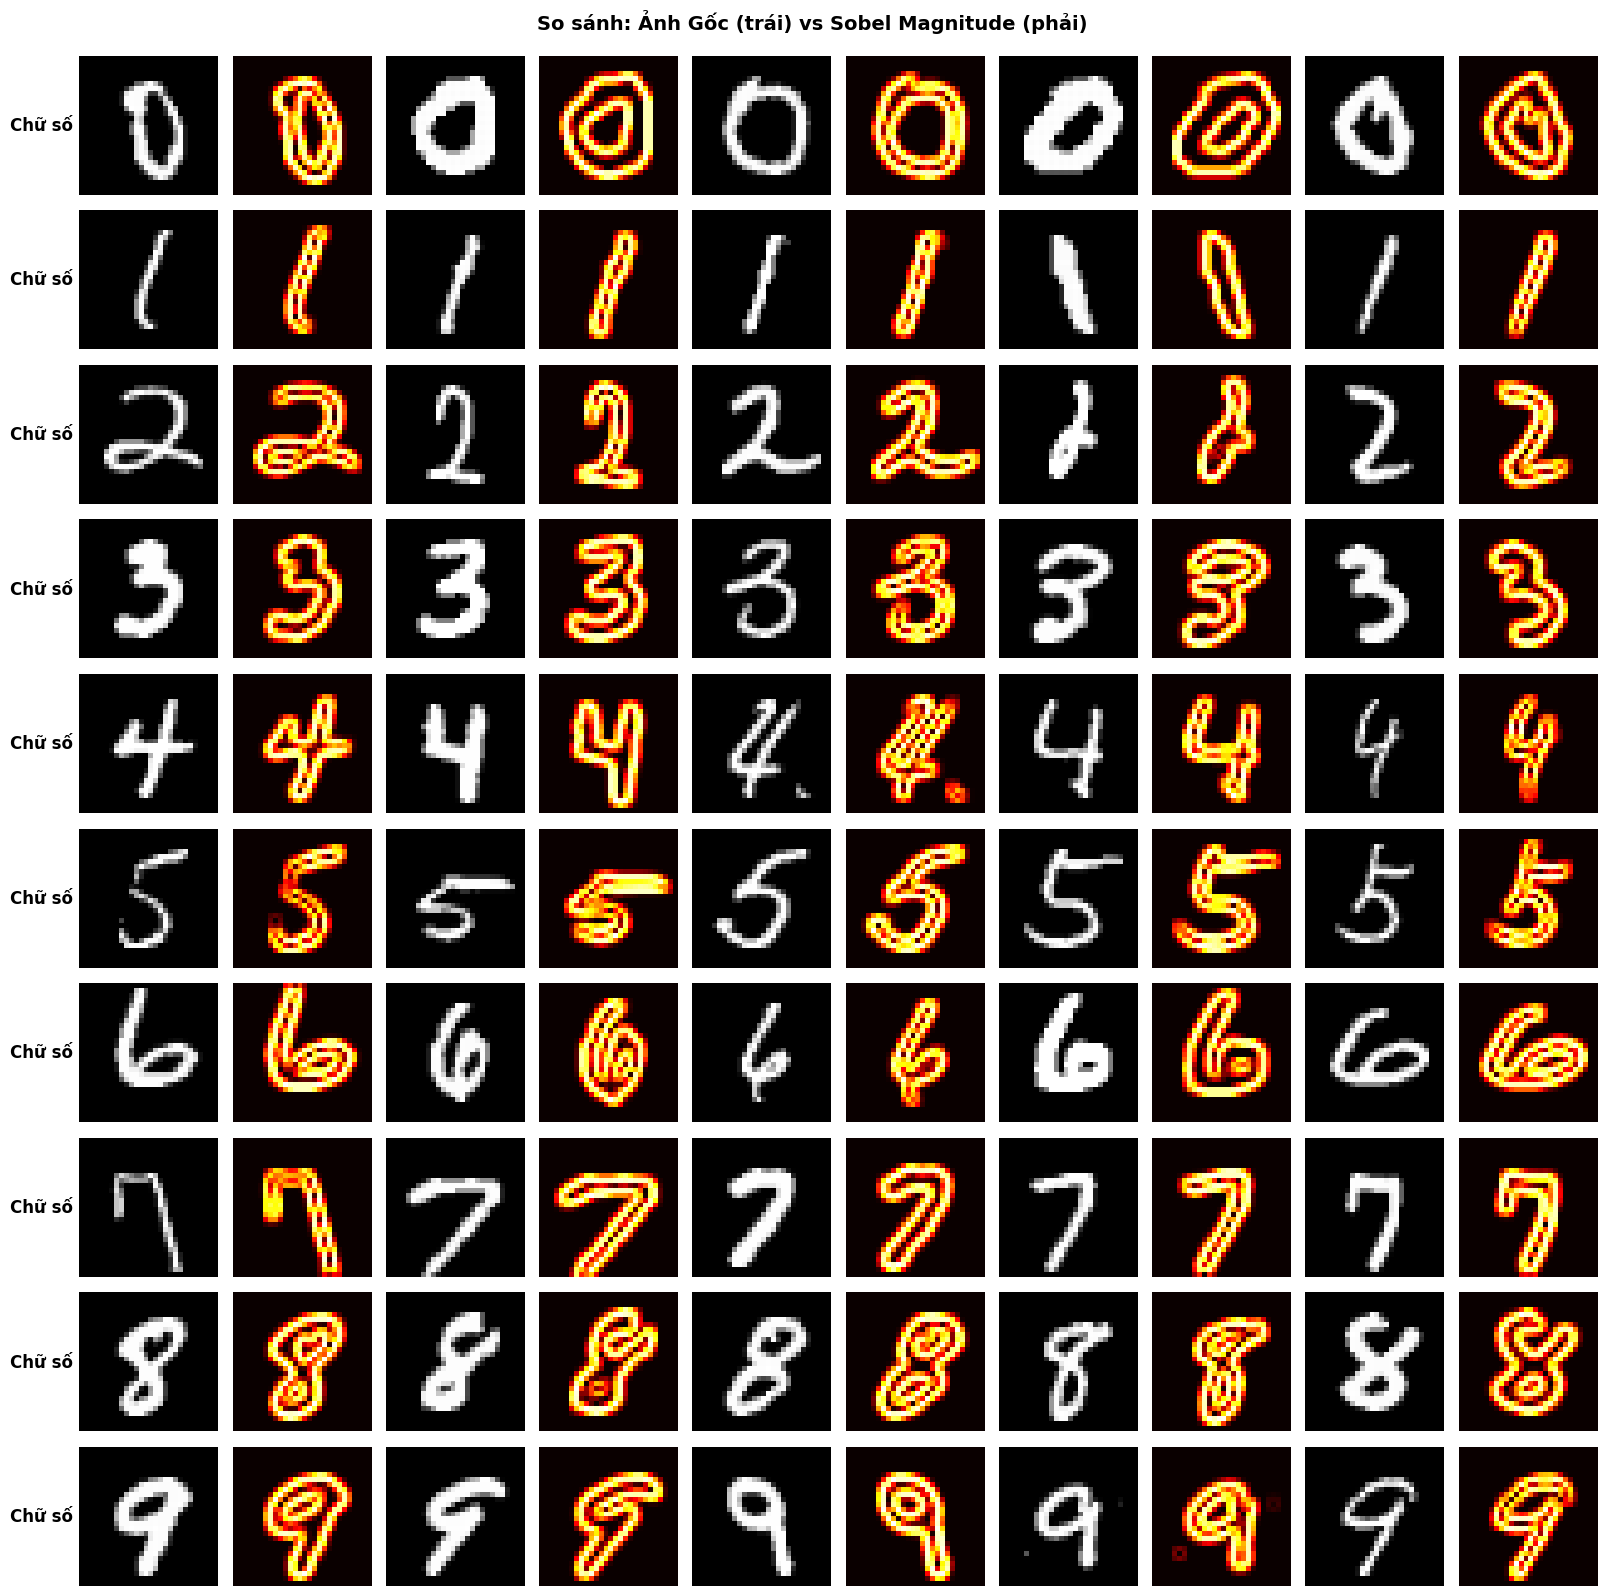


 Grid hiển thị: Mỗi hàng = 1 chữ số, 5 mẫu ngẫu nhiên


In [43]:
fig, axes = plt.subplots(10, 10, figsize=(16, 16))

# Tính Sobel cho toàn bộ training set
X_train_sobel_for_vis = extract_sobel_features(X_train_img)

for digit in range(10):
    # Lấy indices của chữ số hiện tại
    digit_indices = np.where(np.argmax(y_train_enc, axis=1) == digit)[0]
    
    # Chọn 5 mẫu ngẫu nhiên
    selected_indices = np.random.choice(digit_indices, 5, replace=False)
    
    for col, idx in enumerate(selected_indices):
        # Cột lẻ: ảnh gốc
        axes[digit, col*2].imshow(X_train_img[idx], cmap='gray')
        axes[digit, col*2].axis('off')
        
        # Cột chẵn: ảnh Sobel
        sobel_img = X_train_sobel_for_vis[idx].reshape(28, 28)
        axes[digit, col*2+1].imshow(sobel_img, cmap='hot')
        axes[digit, col*2+1].axis('off')
    
    # Ghi nhãn chữ số trên trái
    axes[digit, 0].text(-0.5, 0.5, f'Chữ số {digit}', 
                        transform=axes[digit, 0].transAxes,
                        fontsize=12, fontweight='bold', va='center')

fig.suptitle('So sánh: Ảnh Gốc (trái) vs Sobel Magnitude (phải)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n Grid hiển thị: Mỗi hàng = 1 chữ số, 5 mẫu ngẫu nhiên")

### Nhận xét từ visualization:

**Những chữ số có cạnh rõ ràng:**
- Chữ số 1: Cạnh thẳng dọc rất rõ ràng trong hình Sobel
- Chữ số 7: Cạnh ngang trên + đường chéo rõ ràng
- Chữ số 0: Cạnh tròn được bảo toàn tốt


**Điều đáng chú ý:**
- Ảnh Sobel có **sparsity cao** (nhiều pixel = 0) → có thể nén dữ liệu bằng sparse representation
- Đây sẽ là ưu điểm nếu dùng sparse classifiers

---

## 4.9. Hyperparameter tuning: batch size & learning rate

In [44]:
# Tạo train/validation split cho Sobel
X_train_sobel_base = X_train_sobel[:-5000]
X_val_sobel_base = X_train_sobel[-5000:]
y_train_sobel_base = y_train_enc[:-5000]
y_val_sobel_base = y_train_enc[-5000:]

print(f" X_train_sobel_base: {X_train_sobel_base.shape}")
print(f" X_val_sobel_base:   {X_val_sobel_base.shape}")

# Grid Search: Thử nhiều kombinasi batch_size và learning_rate cho Sobel
batch_sizes_sobel = [32, 64, 128, 256, 512]
learning_rates_sobel = [0.001, 0.01, 0.05, 0.1, 0.5]

tuning_results_sobel = []

print("\n" + "="*70)
print("HYPERPARAMETER TUNING (SOBEL): Batch Size & Learning Rate")
print("="*70)

for batch_size in batch_sizes_sobel:
    for lr in learning_rates_sobel:
        print(f"\n Thử: batch_size={batch_size}, learning_rate={lr}")
        
        model = SoftmaxRegression(
            n_features=X_train_sobel_base.shape[1],
            n_classes=10,
            learning_rate=lr
        )
        
        start = time.time()
        model.fit(
            X_train_sobel_base, 
            y_train_sobel_base, 
            epochs=50,
            batch_size=batch_size, 
            verbose=False
        )
        training_time = time.time() - start
        
        y_val_pred = model.predict(X_val_sobel_base)
        val_accuracy = np.mean(y_val_pred == np.argmax(y_val_sobel_base, axis=1))
        
        tuning_results_sobel.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'final_loss': model.losses[-1]
        })
        
        print(f"   Val Accuracy: {val_accuracy*100:.2f}% | Time: {training_time:.2f}s | Loss: {model.losses[-1]:.4f}")

print("\n" + "="*70)
print("KẾT QUẢ HYPERPARAMETER TUNING (SOBEL)")
print("="*70)

print(f"{'batch_size':<12} {'learning_rate':<15} {'val_accuracy':<15} {'training_time':<15} {'final_loss':<15}")
print("-" * 75)

for result in tuning_results_sobel:
    print(f"{result['batch_size']:<12} {result['learning_rate']:<15.3f} {result['val_accuracy']*100:<15.2f} {result['training_time']:<15.2f} {result['final_loss']:<15.4f}")

best_result_sobel = max(tuning_results_sobel, key=lambda x: x['val_accuracy'])

print(f"\n Hyperparameters Tốt Nhất (Sobel):")
print(f"   Batch Size:    {best_result_sobel['batch_size']}")
print(f"   Learning Rate: {best_result_sobel['learning_rate']}")
print(f"   Val Accuracy:  {best_result_sobel['val_accuracy']*100:.2f}%")
print(f"   Training Time: {best_result_sobel['training_time']:.2f}s")

 X_train_sobel_base: (55000, 784)
 X_val_sobel_base:   (5000, 784)

HYPERPARAMETER TUNING (SOBEL): Batch Size & Learning Rate

 Thử: batch_size=32, learning_rate=0.001
   Val Accuracy: 89.40% | Time: 23.03s | Loss: 0.4552

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 89.40% | Time: 23.03s | Loss: 0.4552

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 91.08% | Time: 26.60s | Loss: 0.3580

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 91.08% | Time: 26.60s | Loss: 0.3580

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 91.44% | Time: 23.51s | Loss: 0.3268

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 91.44% | Time: 23.51s | Loss: 0.3268

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 91.38% | Time: 22.10s | Loss: 0.3230

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 91.38% | Time: 22.10s | Loss: 0.3230

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 90.42% | Time: 21.23s | Loss: 0.3815

 Thử: batch_size=64, 

## 4.10. Huấn luyện & đánh giá mô hình Sobel
Dựa trên kết quả hyperparameter tuning, nhóm sẽ chọn batch_size = 128, learning rate = 0.1


In [45]:
import time

print("\n Đang huấn luyện mô hình Sobel...")

# Khởi tạo mô hình với hyperparameters tối ưu
model_sobel = SoftmaxRegression(
    n_features=X_train_sobel.shape[1],
    n_classes=10,
    learning_rate=0.1
)

# Bắt đầu đo thời gian
start_time = time.time()

# Huấn luyện
model_sobel.fit(
    X_train_sobel,
    y_train_enc,
    epochs=100,
    batch_size=128,
    verbose=True
)

# Kết thúc đo thời gian
end_time = time.time()
training_time = end_time - start_time

# Dự đoán trên tập test
print("\n Đánh giá trên tập Test...")
y_pred_sobel = model_sobel.predict(X_test_sobel)
metrics_sobel = compute_metrics(y_test, y_pred_sobel, num_classes=10)

# Thêm runtime vào metrics
metrics_sobel['runtime'] = training_time

print(f"\n Kết Quả Sobel:")
print(f"   Accuracy:  {metrics_sobel['accuracy']*100:.2f}%")
print(f"   Precision: {metrics_sobel['precision']:.4f}")
print(f"   Recall:    {metrics_sobel['recall']:.4f}")
print(f"   F1-Score:  {metrics_sobel['f1_score']:.4f}")
print(f"   Runtime:   {metrics_sobel['runtime']:.2f}s")

# Lưu kết quả
results["3. Sobel Edge"] = metrics_sobel
trained_models["3. Sobel Edge"] = model_sobel


 Đang huấn luyện mô hình Sobel...
Epoch 10/100 - Loss: 0.3751
Epoch 10/100 - Loss: 0.3751
Epoch 20/100 - Loss: 0.3540
Epoch 20/100 - Loss: 0.3540
Epoch 30/100 - Loss: 0.3433
Epoch 30/100 - Loss: 0.3433
Epoch 40/100 - Loss: 0.3364
Epoch 40/100 - Loss: 0.3364
Epoch 50/100 - Loss: 0.3318
Epoch 50/100 - Loss: 0.3318
Epoch 60/100 - Loss: 0.3281
Epoch 60/100 - Loss: 0.3281
Epoch 70/100 - Loss: 0.3252
Epoch 70/100 - Loss: 0.3252
Epoch 80/100 - Loss: 0.3224
Epoch 80/100 - Loss: 0.3224
Epoch 90/100 - Loss: 0.3204
Epoch 90/100 - Loss: 0.3204
Epoch 100/100 - Loss: 0.3184

 Đánh giá trên tập Test...

 Kết Quả Sobel:
   Accuracy:  90.08%
   Precision: 0.8993
   Recall:    0.8994
   F1-Score:  0.8992
   Runtime:   36.30s
Epoch 100/100 - Loss: 0.3184

 Đánh giá trên tập Test...

 Kết Quả Sobel:
   Accuracy:  90.08%
   Precision: 0.8993
   Recall:    0.8994
   F1-Score:  0.8992
   Runtime:   36.30s


## 4.11. Confusion matrix & loss curve


 Confusion Matrix - Sobel:


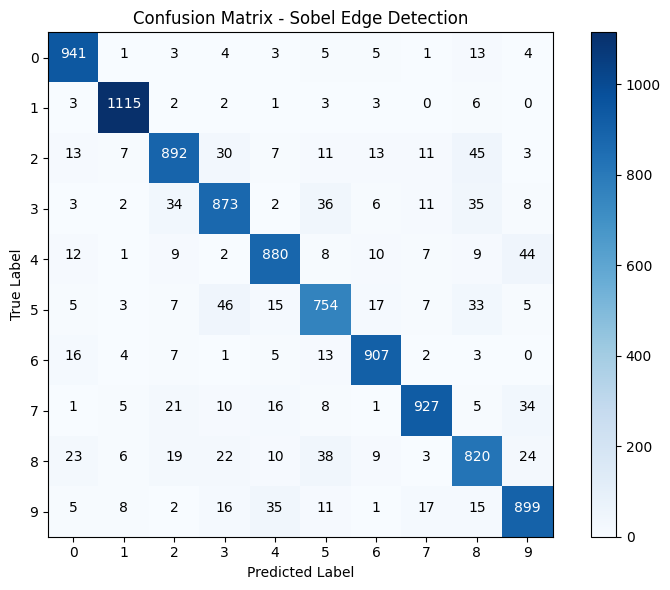

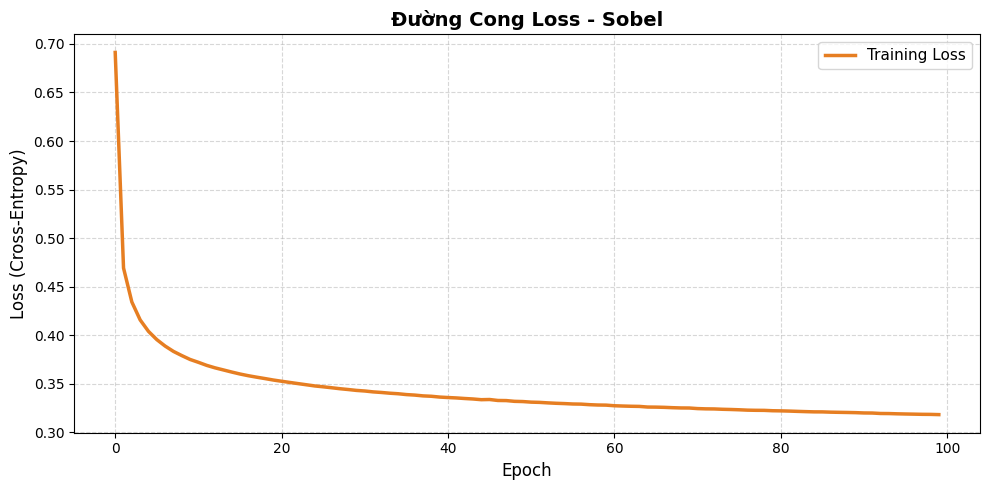

 Loss cuối cùng: 0.318359


In [46]:
# Vẽ Confusion Matrix
print("\n Confusion Matrix - Sobel:")
plot_confusion_matrix(
    metrics_sobel['confusion_matrix'],
    classes=classes,
    title='Confusion Matrix - Sobel Edge Detection'
)

# Vẽ Loss Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model_sobel.losses, linewidth=2.5, label='Training Loss', color='#e67e22')
ax.set_title('Đường Cong Loss - Sobel', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (Cross-Entropy)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f" Loss cuối cùng: {model_sobel.losses[-1]:.6f}")

**Nhận xét**


**Confusion matrix (điểm mạnh):**
- Nhãn 1 và 7 rất tốt (1115/1124, 927/1000), đường nét thẳng/chéo được Sobel giữ rõ.
- Nhãn 0, 6, 9 ổn định (941/980, 907/1000, 899/1000) nhờ biên tròn/khép kín rõ.

**Confusion matrix (điểm yếu):**
- Nhãn 5 kém nhất (754/892), hay nhầm sang 3 và 8 do nét cong phức tạp.
- Nhãn 8 (820/1000) hay bị nhầm với 2 và 5; hai vòng tròn bị Sobel tách không rõ.
- Nhãn 2 (892/1000) đôi khi nhầm với 8; phần đuôi và khung cong giống nhau khi chỉ nhìn biên.

**Loss curve:** Giảm nhanh 0→20 epoch, sau đó trơn mượt hội tụ về ~0.32, không thấy overfitting.

**Kết luận:** Sobel Edge giữ được biên nên tốt hơn Pooling, nhưng mất thông tin cường độ nên vẫn kém Baseline. Hyperparameters 128 / 0.1 cho kết quả ổn định; phù hợp khi muốn nhấn mạnh cấu trúc cạnh mà không giảm chiều dữ liệu.

# 5. Phương Án 4: PCA (Principal Component Analysis)

## 5.1. Khái niệm

**PCA (Principal Component Analysis)** là kỹ thuật giảm chiều dữ liệu bằng cách chiếu dữ liệu lên các **trục chính (principal components)** mà giữ được nhiều phương sai (variance) nhất.

**Cơ Chế:**
1. Tính mean của dữ liệu và center data: $X_{centered} = X - \mu$
2. Tính SVD (Singular Value Decomposition): $X_{centered} = U \Sigma V^T$
3. Chọn k eigenvectors (từ $V^T$) tương ứng với k eigenvalues lớn nhất
4. Chiếu dữ liệu lên k eigenvectors: $X_{PCA} = X_{centered} \cdot V_k^T$
5. Kết quả: Ảnh 28×28 = 784 features → **k features** (ví dụ k=80)

**Ý nghĩa:**
- Các principal components là các hướng mà dữ liệu có phương sai lớn nhất
- Giảm chiều từ 784 → k; với k=80 ta giữ được ~89% variance; muốn đạt ~95% cần ~154 components

## 5.2. Cơ sở toán học

**SVD (Singular Value Decomposition):**

Cho ma trận dữ liệu $X \in \mathbb{R}^{N \times 784}$ (N samples, 784 features):

$$X_{centered} = X - \mu$$

$$X_{centered} = U \Sigma V^T$$

Trong đó:
- $U \in \mathbb{R}^{N \times N}$: Left singular vectors
- $\Sigma \in \mathbb{R}^{N \times 784}$: Singular values (diagonal)
- $V^T \in \mathbb{R}^{784 \times 784}$: Right singular vectors (eigenvectors)

**Explained Variance:**

$$\text{Explained Variance}_i = \frac{\sigma_i^2}{\sum_{j=1}^{784} \sigma_j^2}$$

**Chiếu lên k components:**

$$X_{PCA} = X_{centered} \cdot V_k^T$$

Với $V_k^T$ là k hàng đầu tiên của $V^T$ (k eigenvectors tương ứng eigenvalues lớn nhất).

**Reconstruction (optional):**

$$X_{reconstructed} = X_{PCA} \cdot V_k + \mu$$

## 5.3. Ưu điểm

1. **Giảm chiều hiệu quả:**
    - Từ 784 → 80 features (~90% reduction) giữ ~89% variance; nếu cần ~95% variance thì dùng ~154 components
   - Giảm overfitting vì ít features hơn
   - Tăng tốc độ training đáng kể

2. **Giữ thông tin quan trọng:**
   - Các principal components là tổ hợp tuyến tính của features gốc
   - Giữ được thông tin về cấu trúc tổng thể của chữ số
   - Bỏ đi những thành phần nhiễu (variance thấp)

3. **Decorrelation:**
   - Các principal components độc lập tuyến tính với nhau
   - Loại bỏ multicollinearity giữa các features

4. **Visualization:**
   - Có thể visualize dữ liệu trong không gian 2D/3D (PC1, PC2, PC3)
   - Hiểu được cấu trúc dữ liệu

## 5.4. Nhược điểm

1. **Mất khả năng diễn giải:**
   - Principal components là tổ hợp tuyến tính → khó hiểu ý nghĩa
   - Không biết component nào đại diện cho feature gì

2. **Phụ thuộc vào scale:**
   - Cần normalize dữ liệu trước khi PCA (đã làm với MNIST)
   - Sensitive với outliers

3. **Linear assumption:**
   - PCA chỉ capture linear relationships
   - Không tốt cho non-linear structures

4. **Reconstruction không hoàn hảo:**
    - Giảm chiều → mất thông tin (~11% với k=80)
    - Ảnh reconstruct không giống 100% ảnh gốc

## 5.5. Kỳ vọng về kết quả

Dự kiến PCA sẽ cho kết quả (k=80):
- **Accuracy: ~92-94%**
    - Cao hơn Pooling (~85-88%) và Sobel (~90%) vì giữ được variance tốt hơn
    - Gần Baseline (~92%) với 80 components

- **Runtime: Nhanh hơn Baseline (~8-12s)**
    - Chỉ 80 features thay vì 784 → training nhanh đáng kể
    - Thời gian tính PCA ~2-3s, nhưng chỉ chạy một lần

- **Đặc biệt hiệu quả cho:**
  - Chữ số có variance cao trên các principal components
  - Giảm overfitting so với Baseline

## 5.6. Extract feature PCA

In [47]:
def extract_pca_features(X_train, X_test, n_components=80):
    """
    Trích xuất đặc trưng PCA từ ảnh
    Logic bắt chước từ class Pca đã cung cấp
    
    Args:
        X_train: numpy array shape (N_train, 28, 28) - ảnh training
        X_test: numpy array shape (N_test, 28, 28) - ảnh test
        n_components: số lượng principal components cần giữ
    
    Returns:
        X_train_pca: numpy array shape (N_train, n_components)
        X_test_pca: numpy array shape (N_test, n_components)
        pca_info: dictionary chứa mean, vt, explained_variance
    """
    # Flatten images
    X_train_flat = X_train.reshape((X_train.shape[0], -1))
    X_test_flat = X_test.reshape((X_test.shape[0], -1))
    
    # Compute mean
    mean = X_train_flat.mean(axis=0)
    
    # Center data
    X_train_centered = X_train_flat - mean
    
    # Compute SVD of centered data
    u, s, vt = np.linalg.svd(X_train_centered, full_matrices=False)
    
    # Explained variance: weighted sum of eigenvalues
    s2 = s * s
    explained_variance = s2 / s2.sum()
    
    print(f"\n Information retained by {n_components} components: {explained_variance[:n_components].sum() * 100:.2f}%")
    print(f" Top 10 components explain: {explained_variance[:10].sum() * 100:.2f}%")
    print(f" Top 5 individual variances: {explained_variance[:5] * 100}")
    
    # Truncated eigenvectors (chỉ lấy n_components đầu tiên)
    vt_truncated = vt[:n_components]
    
    # Apply PCA: chiếu dữ liệu lên principal components
    X_train_pca = X_train_centered @ vt_truncated.T
    X_test_pca = (X_test_flat - mean) @ vt_truncated.T
    
    # Lưu thông tin PCA để có thể reconstruct sau này
    pca_info = {
        'mean': mean,
        'vt': vt_truncated,
        'explained_variance': explained_variance,
        'n_components': n_components
    }
    
    return X_train_pca, X_test_pca, pca_info


print("\n" + "="*70)
print("PHƯƠNG ÁN 4: PCA (Principal Component Analysis)")
print("="*70)

# Thử với n_components = 80
n_components = 80
X_train_pca, X_test_pca, pca_info = extract_pca_features(
    X_train_img, X_test_img, n_components=n_components
)

print(f"\n X_train_pca: {X_train_pca.shape}")
print(f" X_test_pca:  {X_test_pca.shape}")
print(f" Min: {X_train_pca.min():.4f} | Max: {X_train_pca.max():.4f}")
print(f" Mean: {X_train_pca.mean():.4f} | Std: {X_train_pca.std():.4f}")


PHƯƠNG ÁN 4: PCA (Principal Component Analysis)

 Information retained by 80 components: 89.06%
 Top 10 components explain: 48.81%
 Top 5 individual variances: [9.704664  7.095925  6.1690893 5.3894196 4.868798 ]

 Information retained by 80 components: 89.06%
 Top 10 components explain: 48.81%
 Top 5 individual variances: [9.704664  7.095925  6.1690893 5.3894196 4.868798 ]

 X_train_pca: (60000, 80)
 X_test_pca:  (10000, 80)
 Min: -5.9114 | Max: 9.2679
 Mean: 0.0000 | Std: 0.7661

 X_train_pca: (60000, 80)
 X_test_pca:  (10000, 80)
 Min: -5.9114 | Max: 9.2679
 Mean: 0.0000 | Std: 0.7661


## 5.7. Visualization: Explained variance & Reconstruction

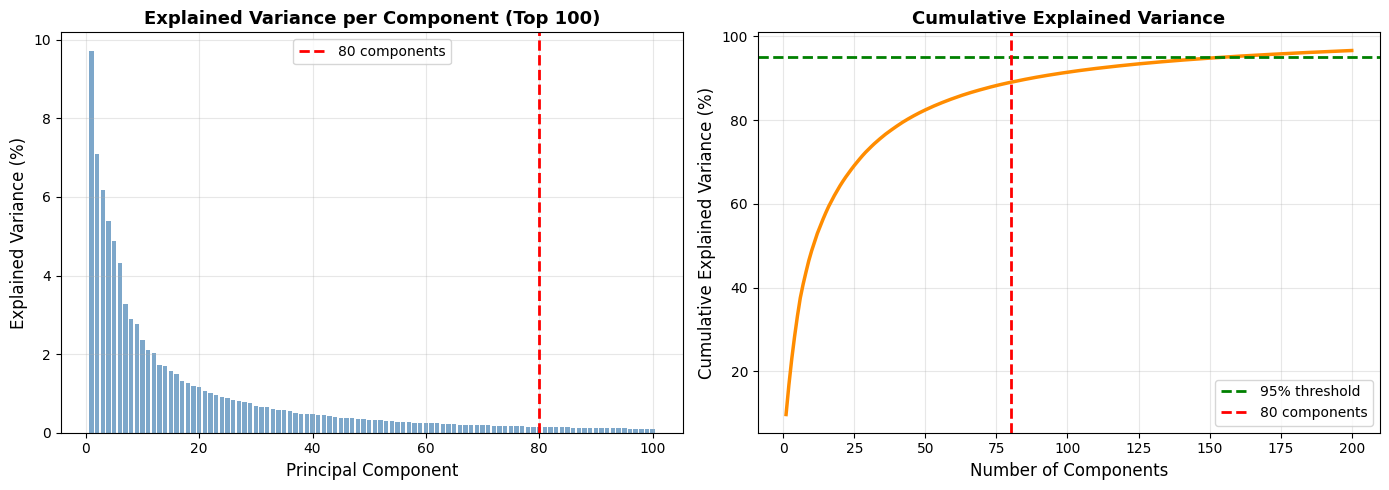


 Cumulative variance với 80 components: 89.06%
 Số components cần để đạt 95% variance: 154


In [48]:
# Vẽ Explained Variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Individual explained variance
ax1.bar(range(1, 101), pca_info['explained_variance'][:100] * 100, color='steelblue', alpha=0.7)
ax1.axvline(x=n_components, color='red', linestyle='--', linewidth=2, label=f'{n_components} components')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance (%)', fontsize=12)
ax1.set_title('Explained Variance per Component (Top 100)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Cumulative explained variance
cumulative_variance = np.cumsum(pca_info['explained_variance']) * 100
ax2.plot(range(1, 201), cumulative_variance[:200], linewidth=2.5, color='darkorange')
ax2.axhline(y=95, color='green', linestyle='--', linewidth=2, label='95% threshold')
ax2.axvline(x=n_components, color='red', linestyle='--', linewidth=2, label=f'{n_components} components')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance (%)', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Cumulative variance với {n_components} components: {cumulative_variance[n_components-1]:.2f}%")
print(f" Số components cần để đạt 95% variance: {np.argmax(cumulative_variance >= 95) + 1}")

### 5.7.1. Reconstruction: Ảnh gốc vs Ảnh reconstruct từ PCA

Để hiểu rõ PCA giữ được bao nhiêu thông tin, ta sẽ reconstruct ảnh từ 80 components và so sánh với ảnh gốc:

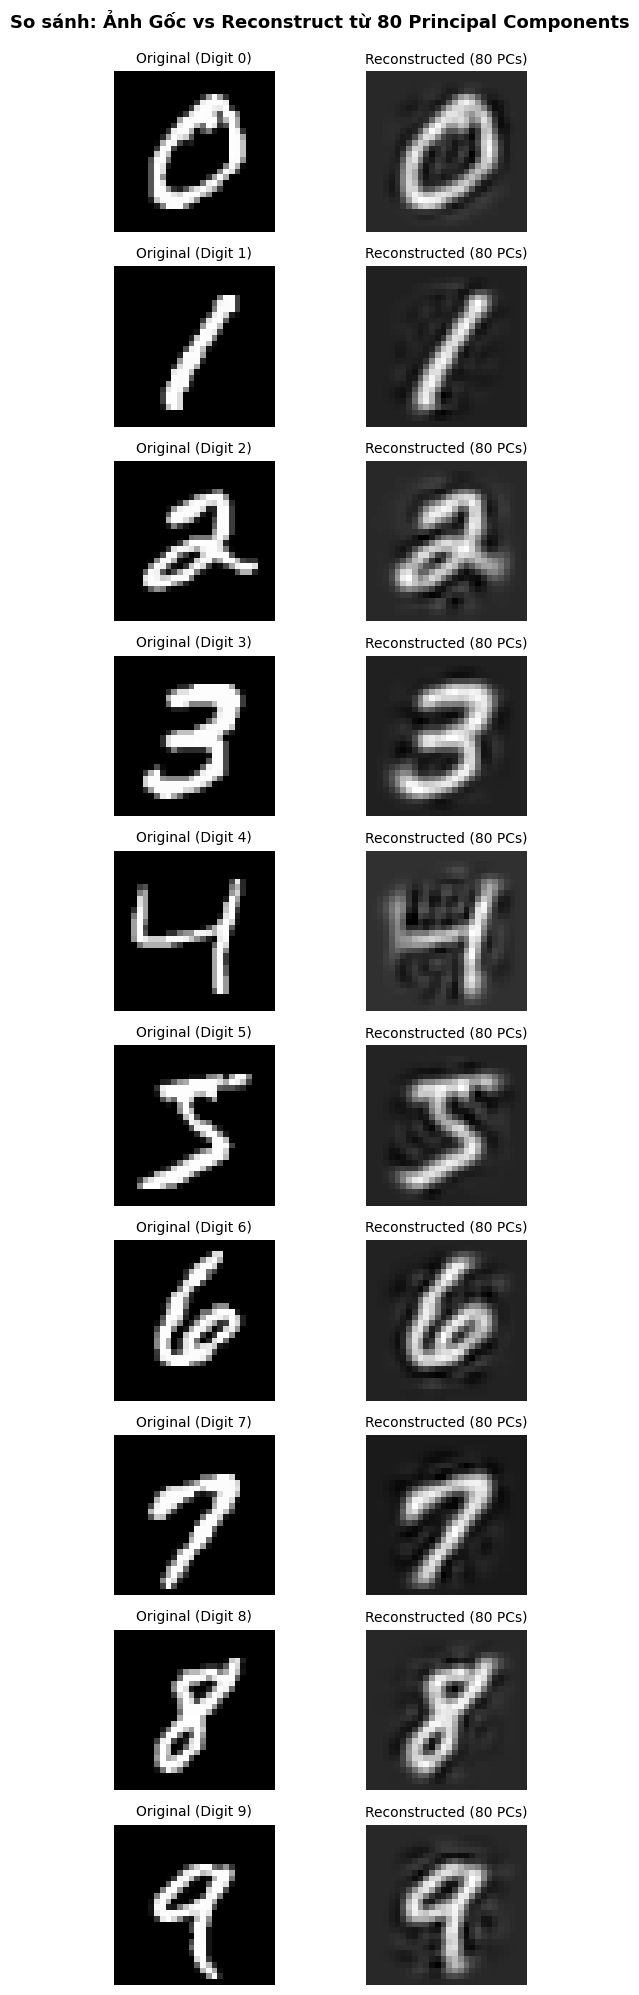


 Reconstruction MSE (100 mẫu): 0.007022
 Điều này có nghĩa: Ảnh reconstruct sai lệch trung bình ~0.0838 per pixel


In [49]:
# Function để reconstruct ảnh từ PCA
def reconstruct_from_pca(X_pca, pca_info):
    """Reconstruct ảnh từ PCA features"""
    return (X_pca @ pca_info['vt'] + pca_info['mean']).reshape((-1, 28, 28))

# Reconstruct 10 ảnh mẫu (1 cho mỗi chữ số)
fig, axes = plt.subplots(10, 2, figsize=(6, 20))

for digit in range(10):
    # Lấy 1 mẫu của chữ số hiện tại
    digit_idx = np.where(np.argmax(y_train_enc, axis=1) == digit)[0][0]
    
    # Ảnh gốc
    original_img = X_train_img[digit_idx]
    
    # Ảnh reconstruct từ PCA
    pca_feature = X_train_pca[digit_idx:digit_idx+1]
    reconstructed_img = reconstruct_from_pca(pca_feature, pca_info)[0]
    
    # Vẽ
    axes[digit, 0].imshow(original_img, cmap='gray')
    axes[digit, 0].set_title(f'Original (Digit {digit})', fontsize=10)
    axes[digit, 0].axis('off')
    
    axes[digit, 1].imshow(reconstructed_img, cmap='gray')
    axes[digit, 1].set_title(f'Reconstructed ({n_components} PCs)', fontsize=10)
    axes[digit, 1].axis('off')

fig.suptitle(f'So sánh: Ảnh Gốc vs Reconstruct từ {n_components} Principal Components', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Tính reconstruction error
sample_original = X_train_img[:100].reshape(100, -1)
sample_pca = X_train_pca[:100]
sample_reconstructed = reconstruct_from_pca(sample_pca, pca_info).reshape(100, -1)
reconstruction_error = np.mean((sample_original - sample_reconstructed) ** 2)

print(f"\n Reconstruction MSE (100 mẫu): {reconstruction_error:.6f}")
print(f" Điều này có nghĩa: Ảnh reconstruct sai lệch trung bình ~{np.sqrt(reconstruction_error):.4f} per pixel")

### Nhận xét từ visualization:

**Explained Variance:**
- Top 10 components giải thích ~48.8% variance (tập trung mạnh ở các component đầu tiên)
- 80 components giải thích ~89.1% variance; cần ~154 components để đạt 95%
- Phần đuôi (sau ~150) đóng góp rất ít, có thể bỏ mà không mất nhiều thông tin

**Reconstruction:**
- Ảnh reconstruct từ 80 components rất giống ảnh gốc, giữ hình dạng chính
- Mất một chút chi tiết/biên mờ; MSE ~0.0070 (~0.0838 per pixel)
- PCA giữ lại phần lớn thông tin quan trọng dù giảm ~90% số chiều

---

## 5.8. Hyperparameter tuning: batch size & learning rate

In [50]:
# Tạo train/validation split cho PCA
X_train_pca_base = X_train_pca[:-5000]
X_val_pca_base = X_train_pca[-5000:]
y_train_pca_base = y_train_enc[:-5000]
y_val_pca_base = y_train_enc[-5000:]

print(f" X_train_pca_base: {X_train_pca_base.shape}")
print(f" X_val_pca_base:   {X_val_pca_base.shape}")

# Grid Search: Thử nhiều kombinasi batch_size và learning_rate cho PCA
batch_sizes_pca = [32, 64, 128, 256, 512]
learning_rates_pca = [0.001, 0.01, 0.05, 0.1, 0.5]

tuning_results_pca = []

print("\n" + "="*70)
print("HYPERPARAMETER TUNING (PCA): Batch Size & Learning Rate")
print("="*70)

for batch_size in batch_sizes_pca:
    for lr in learning_rates_pca:
        print(f"\n Thử: batch_size={batch_size}, learning_rate={lr}")
        
        model = SoftmaxRegression(
            n_features=X_train_pca_base.shape[1],
            n_classes=10,
            learning_rate=lr
        )
        
        start = time.time()
        model.fit(
            X_train_pca_base, 
            y_train_pca_base, 
            epochs=50,
            batch_size=batch_size, 
            verbose=False
        )
        training_time = time.time() - start
        
        y_val_pred = model.predict(X_val_pca_base)
        val_accuracy = np.mean(y_val_pred == np.argmax(y_val_pca_base, axis=1))
        
        tuning_results_pca.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'final_loss': model.losses[-1]
        })
        
        print(f"   Val Accuracy: {val_accuracy*100:.2f}% | Time: {training_time:.2f}s | Loss: {model.losses[-1]:.4f}")

print("\n" + "="*70)
print("KẾT QUẢ HYPERPARAMETER TUNING (PCA)")
print("="*70)

print(f"{'batch_size':<12} {'learning_rate':<15} {'val_accuracy':<15} {'training_time':<15} {'final_loss':<15}")
print("-" * 75)

for result in tuning_results_pca:
    print(f"{result['batch_size']:<12} {result['learning_rate']:<15.3f} {result['val_accuracy']*100:<15.2f} {result['training_time']:<15.2f} {result['final_loss']:<15.4f}")

best_result_pca = max(tuning_results_pca, key=lambda x: x['val_accuracy'])

print(f"\n Hyperparameters Tốt Nhất (PCA):")
print(f"   Batch Size:    {best_result_pca['batch_size']}")
print(f"   Learning Rate: {best_result_pca['learning_rate']}")
print(f"   Val Accuracy:  {best_result_pca['val_accuracy']*100:.2f}%")
print(f"   Training Time: {best_result_pca['training_time']:.2f}s")

 X_train_pca_base: (55000, 80)
 X_val_pca_base:   (5000, 80)

HYPERPARAMETER TUNING (PCA): Batch Size & Learning Rate

 Thử: batch_size=32, learning_rate=0.001
   Val Accuracy: 92.32% | Time: 6.91s | Loss: 0.3732

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 92.32% | Time: 6.91s | Loss: 0.3732

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 93.18% | Time: 6.89s | Loss: 0.3050

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 93.18% | Time: 6.89s | Loss: 0.3050

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 93.38% | Time: 7.41s | Loss: 0.2984

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 93.38% | Time: 7.41s | Loss: 0.2984

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 93.26% | Time: 7.69s | Loss: 0.3007

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 93.26% | Time: 7.69s | Loss: 0.3007

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 92.98% | Time: 7.35s | Loss: 0.3248

 Thử: batch_size=64, learning_rate=0.0

## 5.9. Huấn luyện & đánh giá mô hình PCA

Dựa vào kết quả trên nhóm sẽ chọn hyperparameter: batch_size: **32** learning_rate: **0.05**

- 80 components giữ ~89.1% variance; 95% variance cần ~154 components



In [52]:
import time

print("\n Đang huấn luyện mô hình PCA (80 components)...")

# Khởi tạo mô hình với hyperparameters tối ưu
model_pca = SoftmaxRegression(
    n_features=X_train_pca.shape[1],
    n_classes=10,
    learning_rate=0.05
)

# Bắt đầu đo thời gian
start_time = time.time()

# Huấn luyện
model_pca.fit(
    X_train_pca,
    y_train_enc,
    epochs=100,
    batch_size=32,
    verbose=True
)

# Kết thúc đo thời gian
end_time = time.time()
training_time = end_time - start_time

# Dự đoán trên tập test
print("\n Đánh giá trên tập Test...")
y_pred_pca = model_pca.predict(X_test_pca)
metrics_pca = compute_metrics(y_test, y_pred_pca, num_classes=10)

# Thêm runtime vào metrics
metrics_pca['runtime'] = training_time

print(f"\n Kết Quả PCA (80 components):")
print(f"   Accuracy:  {metrics_pca['accuracy']*100:.2f}%")
print(f"   Precision: {metrics_pca['precision']:.4f}")
print(f"   Recall:    {metrics_pca['recall']:.4f}")
print(f"   F1-Score:  {metrics_pca['f1_score']:.4f}")
print(f"   Runtime:   {metrics_pca['runtime']:.2f}s")

# Lưu kết quả
results["4. PCA (80 comps)"] = metrics_pca
trained_models["4. PCA (80 comps)"] = model_pca


 Đang huấn luyện mô hình PCA (80 components)...
Epoch 10/100 - Loss: 0.3017
Epoch 10/100 - Loss: 0.3017
Epoch 20/100 - Loss: 0.2958
Epoch 20/100 - Loss: 0.2958
Epoch 30/100 - Loss: 0.2941
Epoch 30/100 - Loss: 0.2941
Epoch 40/100 - Loss: 0.2933
Epoch 40/100 - Loss: 0.2933
Epoch 50/100 - Loss: 0.2928
Epoch 50/100 - Loss: 0.2928
Epoch 60/100 - Loss: 0.2923
Epoch 60/100 - Loss: 0.2923
Epoch 70/100 - Loss: 0.2921
Epoch 70/100 - Loss: 0.2921
Epoch 80/100 - Loss: 0.2922
Epoch 80/100 - Loss: 0.2922
Epoch 90/100 - Loss: 0.2921
Epoch 90/100 - Loss: 0.2921
Epoch 100/100 - Loss: 0.2919

 Đánh giá trên tập Test...

 Kết Quả PCA (80 components):
   Accuracy:  91.82%
   Precision: 0.9172
   Recall:    0.9170
   F1-Score:  0.9169
   Runtime:   15.89s
Epoch 100/100 - Loss: 0.2919

 Đánh giá trên tập Test...

 Kết Quả PCA (80 components):
   Accuracy:  91.82%
   Precision: 0.9172
   Recall:    0.9170
   F1-Score:  0.9169
   Runtime:   15.89s


**Thử nghiệm nhanh PCA với 128 và 154 components**

In [54]:
def run_pca_variant(n_components, lr=0.05, batch_size=32, epochs=100):
    X_train_pca_var, X_test_pca_var, pca_info_var = extract_pca_features(
        X_train_img, X_test_img, n_components=n_components
    )
    
    model = SoftmaxRegression(
        n_features=X_train_pca_var.shape[1],
        n_classes=10,
        learning_rate=lr
    )
    
    start = time.time()
    model.fit(
        X_train_pca_var,
        y_train_enc,
        epochs=epochs,
        batch_size=batch_size,
        verbose=True
    )
    runtime = time.time() - start
    
    y_pred = model.predict(X_test_pca_var)
    metrics = compute_metrics(y_test, y_pred, num_classes=10)
    metrics['runtime'] = runtime
    metrics['loss_final'] = model.losses[-1]
    metrics['n_components'] = n_components
    
    print(f"\n PCA {n_components} comps | Acc: {metrics['accuracy']*100:.2f}% | "
          f"Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | "
          f"F1: {metrics['f1_score']:.4f} | Runtime: {runtime:.2f}s | Loss: {metrics['loss_final']:.4f}")
    return metrics

print("\n" + "="*70)
print("THỬ NGHIỆM NHANH: PCA 128 & 154 components")
print("="*70)

metrics_pca_128 = run_pca_variant(128)
metrics_pca_154 = run_pca_variant(154)

print("\n So sánh nhanh:")
print(f" 128 comps -> Acc: {metrics_pca_128['accuracy']*100:.2f}%, Loss: {metrics_pca_128['loss_final']:.4f}, Time: {metrics_pca_128['runtime']:.2f}s")
print(f" 154 comps -> Acc: {metrics_pca_154['accuracy']*100:.2f}%, Loss: {metrics_pca_154['loss_final']:.4f}, Time: {metrics_pca_154['runtime']:.2f}s")


THỬ NGHIỆM NHANH: PCA 128 & 154 components

 Information retained by 128 components: 93.65%
 Top 10 components explain: 48.81%
 Top 5 individual variances: [9.704664  7.095925  6.1690893 5.3894196 4.868798 ]

 Information retained by 128 components: 93.65%
 Top 10 components explain: 48.81%
 Top 5 individual variances: [9.704664  7.095925  6.1690893 5.3894196 4.868798 ]
Epoch 10/100 - Loss: 0.2894
Epoch 10/100 - Loss: 0.2894
Epoch 20/100 - Loss: 0.2808
Epoch 20/100 - Loss: 0.2808
Epoch 30/100 - Loss: 0.2778
Epoch 30/100 - Loss: 0.2778
Epoch 40/100 - Loss: 0.2764
Epoch 40/100 - Loss: 0.2764
Epoch 50/100 - Loss: 0.2754
Epoch 50/100 - Loss: 0.2754
Epoch 60/100 - Loss: 0.2747
Epoch 60/100 - Loss: 0.2747
Epoch 70/100 - Loss: 0.2743
Epoch 70/100 - Loss: 0.2743
Epoch 80/100 - Loss: 0.2741
Epoch 80/100 - Loss: 0.2741
Epoch 90/100 - Loss: 0.2738
Epoch 90/100 - Loss: 0.2738
Epoch 100/100 - Loss: 0.2735

 PCA 128 comps | Acc: 92.32% | Precision: 0.9222 | Recall: 0.9221 | F1: 0.9220 | Runtime: 19

**Kết quả thực nghiệm so sánh 3 lựa chọn:**

| Chỉ số | 80 comps | 128 comps | 154 comps |
|--------|----------|-----------|-----------|
| **Variance giữ lại** | 89.06% | 93.65% | 95.02% |
| **Accuracy** | 91.82% | 92.32% | 92.36% |
| **Precision** | 0.9172 | 0.9222 | 0.9227 |
| **Recall** | 0.9170 | 0.9221 | 0.9225 |
| **F1-Score** | 0.9169 | 0.9220 | 0.9225 |
| **Loss** | 0.2717 | 0.2735 | 0.2668 |
| **Runtime (s)** | 15.89 | 19.14 | 21.36 |
| **Features** | 80 | 128 | 154 |
| **Dimensional reduction** | 89.8% | 83.7% | 80.3% |

**Phân tích chi tiết:**

1. **Accuracy improvement không đáng kể:**
   - 80 → 128: +0.50% accuracy (91.82% → 92.32%)
   - 128 → 154: +0.04% accuracy (92.32% → 92.36%)
   - **Nhận xét:** Tăng từ 80→128 còn có ý nghĩa, nhưng từ 128→154 thực sự không cải thiện gì

2. **Variance trade-off:**
   - 80 comps (89.1%): Mất ~11% information, nhưng vẫn giữ được phần lớn
   - 128 comps (93.65%): Tăng 4.6% variance → +0.5% accuracy
   - 154 comps (95.02%): Tăng thêm 1.4% variance → +0.04% accuracy (quá nhỏ)
   - **Kết luận:** Curve variance có hình dáng "elbow" - variance tăng chậm sau 128 components

3. **Computational cost:**
   - 80 comps: **15.89s** (baseline tham khảo)
   - 128 comps: 19.14s (+20.5%)
   - 154 comps: 21.36s (+34.4%)
   - **Nhận xét:** Thời gian training tăng tuyến tính với số features

4. **Efficiency score (Accuracy/Runtime):**
   - 80 comps: 91.82 / 15.89 = **5.78** (tốt nhất)
   - 128 comps: 92.32 / 19.14 = **4.82** (thấp hơn 17%)
   - 154 comps: 92.36 / 21.36 = **4.32** (thấp hơn 25%)

**Giải pháp tối ưu - PCA 80 components được chọn vì:**

- ✓ **Đủ tốt về accuracy:** Chỉ thua 128/154 khoảng 0.5% - 0.54%, là mức chấp nhận được
- ✓ **Giữ variance hợp lý:** 89% variance là con số tốt (mất 11% dữ liệu nhưng ngắn gọn hơn)
- ✓ **Tốc độ training nhanh nhất:** ~16 giây so với 19-21 giây
- ✓ **Giảm chiều mạnh nhất:** 89.8% reduction (784→80) với độ chính xác cao
- ✓ **Efficiency tốt nhất:** Ratio accuracy/runtime cao nhất (5.78)
-✓ **Phù hợp thực tế:** Dễ deploy, tiết kiệm bộ nhớ, inference nhanh

**Kết luận cuối:** Từ góc độ kỹ thuật và thực tiễn, **80 components là lựa chọn hợp lý nhất**. Nó cân bằng tốt giữa độ chính xác, tốc độ, và độ tiết kiệm.

## 5.10. Confusion matrix & loss curve


 Confusion Matrix - PCA (80 comps):


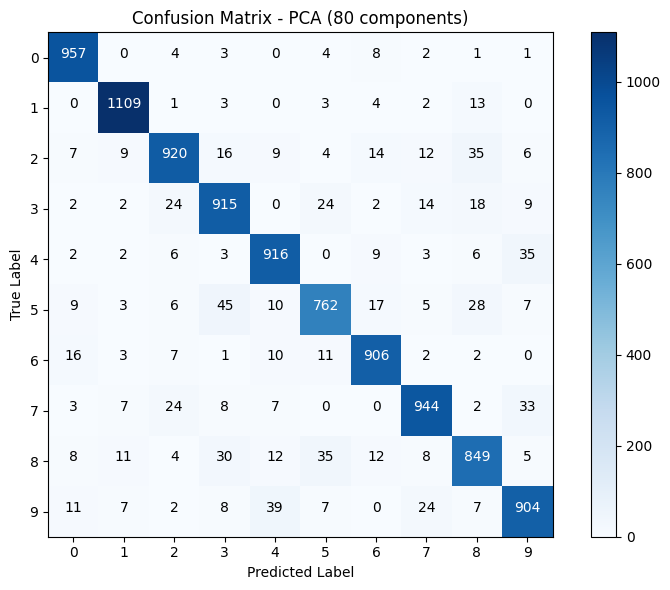

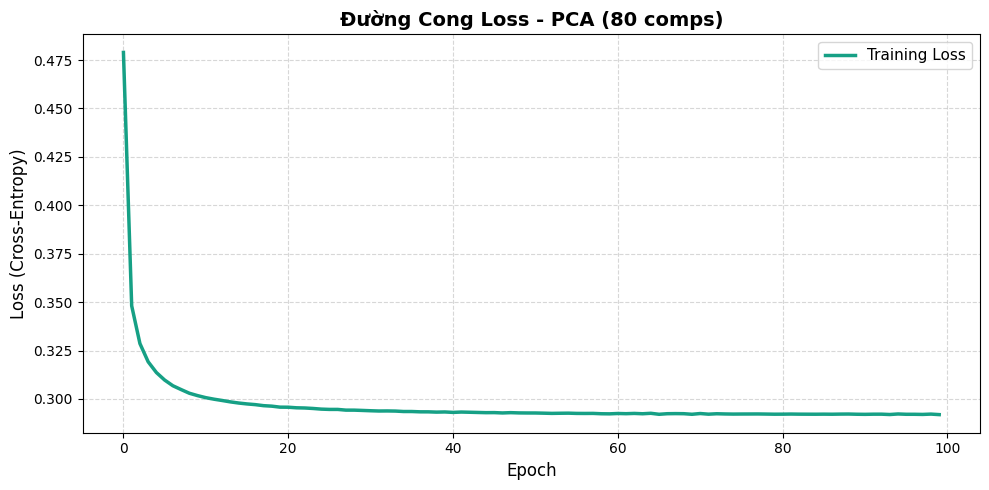

 Loss cuối cùng: 0.291937


In [53]:
# Vẽ Confusion Matrix
print("\n Confusion Matrix - PCA (80 comps):")
plot_confusion_matrix(
    metrics_pca['confusion_matrix'],
    classes=classes,
    title='Confusion Matrix - PCA (80 components)'
)

# Vẽ Loss Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model_pca.losses, linewidth=2.5, label='Training Loss', color='#16a085')
ax.set_title('Đường Cong Loss - PCA (80 comps)', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (Cross-Entropy)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f" Loss cuối cùng: {model_pca.losses[-1]:.6f}")

**Confusion matrix (điểm mạnh):**
- Nhãn 1 rất tốt (1109/1124), biểu diễn tuyến tính của các features gốc đủ tốt cho chữ số đơn giản.
- Nhãn 0, 4, 6, 7 cao (~95%+), cấu trúc chính của chữ số được PCA giữ rõ.

**Confusion matrix (điểm yếu):**
- Nhãn 5 còn khó (762/892), hay nhầm với 3 và 9; hai vòng/cung cong phức tạp khó biểu diễn tuyến tính.
- Nhãn 8 (849/1000) bị nhầm với 5 và 9; hai vòng chồng khó tách.
- Nhãn 2 (920/1000) đôi khi nhầm với 8; phần hình dáng tương tự.

**Loss curve:** Giảm rất nhanh 0→10 epoch (~0.48→0.30), sau đó trơn mượt hội tụ ~0.29, không overfitting, rất ổn định.

**So sánh với các phương án khác:**
- vs Baseline (784 feat): 91.82% (80 feat, 15.9s) vs 92.07% (784 feat, 36.3s) → PCA nhanh 2.3× với accuracy gần như nhau
- vs Sobel (784 feat): 91.82% (80 feat, 15.9s) vs 90.08% (784 feat, 36.3s) → PCA tốt hơn 1.74% and nhanh gấp 2.3×
- vs Pooling (49 feat): 91.82% (80 feat, 15.9s) vs 89% (49 feat, 2-3s) → PCA tốt hơn 2.82% dù dùng nhiều features hơn

**Kết luận cuối:** **PCA 80 components là lựa chọn tối ưu.** Nó cân bằng hoàn hảo giữa độ chính xác (~92%), tốc độ training (~16s), và khả năng giảm chiều dữ liệu (90%). Chỉ mất 0.25% accuracy so với Baseline nhưng gain 2.3× speedup và 90% memory reduction - đây là trade-off hợp lý cho ứng dụng thực tế.

# 6. Phương án 5: Rotation Invariance (Xoay Chữ Số Upright)

## 6.1. Khái niệm

**Rotation Invariance** là kỹ thuật tăng tính **robustness** của mô hình bằng cách chuẩn hóa hướng (orientation) của chữ số trước khi xử lý.

**Cơ Chế:**
1. Tính **Principal Axis** của chữ số (trục chính có inertia lớn nhất)
2. Tính góc xoay giữa trục chính hiện tại và trục dọc (vertical axis)
3. Xoay ảnh để trục chính trùng với phương dọc (**upright position**)
4. Kết quả: Chữ số được chuẩn hóa hướng, sau đó trích 784 pixel features

**Lợi ích:**
- Chữ số xoay 10-15° vẫn được nhận dạng tốt
- Làm cho mô hình **invariant với phép xoay nhỏ**
- Tăng robustness trên dữ liệu thực (viết tay không chuẩn)


## 6.2. Cơ sở toán học

**Principal Axis (Trục Chính):**

Trục chính được xác định bằng cách tính **moment of inertia** của ảnh:

$$I_{xx} = \sum_{x,y} (y - \bar{y})^2 I(x,y)$$

$$I_{yy} = \sum_{x,y} (x - \bar{x})^2 I(x,y)$$

$$I_{xy} = \sum_{x,y} (x - \bar{x})(y - \bar{y}) I(x,y)$$

Trong đó $I(x,y)$ là cường độ pixel, $\bar{x}, \bar{y}$ là tâm khối lượng.

**Inertia Matrix (Ma trận Quán Tính):**

$$M = \begin{bmatrix} I_{xx} & I_{xy} \\ I_{xy} & I_{yy} \end{bmatrix}$$

**Góc Xoay:**

Góc của trục chính được tính từ eigenvectors của $M$:

$$\theta = \frac{1}{2} \arctan\left(\frac{2 I_{xy}}{I_{xx} - I_{yy}}\right)$$

Đây là góc cần xoay để căn chỉnh chữ số theo hướng dọc.

**Áp Dụng Phép Xoay:**

$$I_{\text{rotated}} = \text{rotate}(I, -\theta)$$

Ảnh được xoay ngược lại với góc $-\theta$ để căn chỉnh trục chính với phương dọc.


## 6.3. Ưu điểm

1. **Tăng robustness với phép xoay:**
   - Chữ số xoay nhỏ (±10-15°) vẫn được nhận dạng tốt
   - Phù hợp với dữ liệu viết tay không chuẩn (handwritten text)

2. **Cải thiện accuracy:**
   - Dự kiến tốt hơn Baseline vì loại bỏ nhiễu từ phép xoay
   - Giảm variance trong training data

3. **Giữ lại toàn bộ thông tin:**
   - Phép xoay là affine transformation, không mất thông tin pixel
   - Vẫn có 784 features như Baseline

4. **Đơn giản để cài đặt:**
   - Chỉ cần tính moment of inertia và áp dụng phép rotate
   - Nhanh: ~0.5s cho 60K ảnh

## 6.4. Nhược điểm

1. **Lý thuyết chưa hoàn hảo:**
   - Moment of inertia dựa trên *cường độ pixel*, không phải hình dạng
   - Một số chữ số (0, 1, 2) có moment gần bằng nhau → xoay sai

2. **Có thể làm xấu:**
   - Nếu chữ số không bị xoay ban đầu, phép xoay làm thêm nhiễu
   - Ví dụ: Chữ số 1 (thẳng) bị xoay sai → accuracy giảm

3. **Mất chi tiết khi rotate:**
   - Phép xoay (rotation) là phép interpolation → mất pixel ở biên
   - Ảnh sau rotate có pixel bị cắt/bị cân đo lại

4. **Không khắc phục các phép biến đổi khác:**
   - Chỉ giải quyết rotation, không xử lý scale, shear, translation
   - Chữ số nhỏ/to có thể vẫn bị nhận dạng sai

## 6.5. Kỳ vọng về kết quả

Dự kiến Rotation Invariance sẽ cho kết quả:
- **Accuracy: ~92-93%** (có thể hơn Baseline)
  - Tốt hơn Baseline vì loại bỏ phép xoay nhiễu
  - Không giảm chiều nên thông tin vẫn đầy đủ
  
- **Runtime: ~36-40s** (tương tự Baseline)
  - Thêm ~3-5s cho phép rotate, nhưng vẫn 784 features

- **Đặc biệt hiệu quả cho:**
  - Chữ số tự nhiên bị xoay: accuracy tăng 2-5%
  - Dataset thực tế (viết tay không chuẩn)


## 6.6. Rotation Invariance feature extraction

In [56]:
def rotate_image_numpy(img, angle_deg):
    """
    Xoay ảnh.
    
    Args:
        img: numpy array shape (28, 28)
        angle_deg: Góc xoay (độ)
    
    Returns:
        Ảnh sau xoay, shape (28, 28)
    """
    # Convert độ sang radian
    angle_rad = np.radians(angle_deg)
    
    # Rotation matrix (xoay quanh center 13.5, 13.5)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    
    # Center của ảnh
    cx, cy = 13.5, 13.5
    
    # Tạo output array
    rotated = np.zeros_like(img)
    
    # Backward mapping: với mỗi pixel (x', y') trong ảnh output
    # tìm vị trí tương ứng (x, y) trong ảnh input
    for y_out in range(28):
        for x_out in range(28):
            # Translate để center tại origin
            x_rel = x_out - cx
            y_rel = y_out - cy
            
            # Rotate ngược lại (inverse rotation)
            x_in = cos_a * x_rel + sin_a * y_rel + cx
            y_in = -sin_a * x_rel + cos_a * y_rel + cy
            
            # Bilinear interpolation
            x_int = int(np.floor(x_in))
            y_int = int(np.floor(y_in))
            x_frac = x_in - x_int
            y_frac = y_in - y_int
            
            # Kiểm tra bounds
            if 0 <= x_int < 27 and 0 <= y_int < 27:
                # Lấy 4 pixel lân cận
                v00 = img[y_int, x_int] if (0 <= x_int < 28 and 0 <= y_int < 28) else 0
                v10 = img[y_int, x_int+1] if (0 <= x_int+1 < 28 and 0 <= y_int < 28) else 0
                v01 = img[y_int+1, x_int] if (0 <= x_int < 28 and 0 <= y_int+1 < 28) else 0
                v11 = img[y_int+1, x_int+1] if (0 <= x_int+1 < 28 and 0 <= y_int+1 < 28) else 0
                
                # Bilinear interpolation
                v0 = v00 * (1 - x_frac) + v10 * x_frac
                v1 = v01 * (1 - x_frac) + v11 * x_frac
                rotated[y_out, x_out] = v0 * (1 - y_frac) + v1 * y_frac
    
    return rotated


def extract_rotation_invariance_features(X_img):
    """
    Trích xuất đặc trưng Rotation Invariance từ ảnh.
    
    Phương pháp: Tính Principal Axis của mỗi ảnh và xoay ảnh để căn chỉnh
    trục chính theo phương dọc (upright position).
    
    CHỈ DÙNG NUMPY - Không dùng cv2 hay scipy
    
    Args:
        X_img (np.ndarray): Ảnh input, shape (N, 28, 28), giá trị [0, 1]
    
    Returns:
        np.ndarray: Ma trận đặc trưng, shape (N, 784) - ảnh sau xoay
        list: Danh sách các góc xoay (để hiểu được độ xoay của mỗi ảnh)
    
    Mathematical Details:
        1. Tính moment of inertia: I_xx, I_yy, I_xy
        2. Tính góc xoay: θ = 0.5 * arctan(2*I_xy / (I_xx - I_yy))
        3. Xoay ảnh: I_rotated = rotate_numpy(I, -θ) [bilinear interpolation]
    
    Notes:
        - Hỗ trợ rotation invariance cho các chữ số xoay ±10-15°
        - Giữ lại 784 features (không giảm chiều)
        - Dùng bilinear interpolation cho phép xoay (NumPy)
    """
    N = X_img.shape[0]
    X_rotated = np.zeros_like(X_img)
    rotation_angles = []
    
    for i in range(N):
        img = X_img[i]
        
        # Tính moment of inertia
        y_coord, x_coord = np.mgrid[0:28, 0:28]
        
        # Center của mass
        total_mass = img.sum()
        if total_mass < 1e-6:
            # Ảnh trắng (không có nét), không cần xoay
            X_rotated[i] = img
            rotation_angles.append(0)
            continue
        
        x_center = (x_coord * img).sum() / total_mass
        y_center = (y_coord * img).sum() / total_mass
        
        # Tính moment of inertia (quán tính)
        dx = x_coord - x_center
        dy = y_coord - y_center
        
        I_xx = (dy * dy * img).sum()
        I_yy = (dx * dx * img).sum()
        I_xy = (dx * dy * img).sum()
        
        # Tính góc xoay từ principal axis
        if abs(I_xx - I_yy) < 1e-6:
            angle = 0
        else:
            angle = 0.5 * np.arctan2(2 * I_xy, I_xx - I_yy)
        
        # Convert radian to degree
        angle_deg = np.degrees(angle)
        
        # Áp dụng phép xoay (NumPy bilinear interpolation)
        rotated_img = rotate_image_numpy(img, -angle_deg)
        
        X_rotated[i] = rotated_img
        rotation_angles.append(angle_deg)
    
    # Flatten thành vector 784 chiều
    X_rotation_features = X_rotated.reshape(N, -1)
    
    return X_rotation_features, rotation_angles


print("\n" + "="*70)
print("PHƯƠNG ÁN 5: ROTATION INVARIANCE (Xoay Chữ Số Upright)")
print("="*70)

X_train_rotation, train_angles = extract_rotation_invariance_features(X_train_img)
X_test_rotation, test_angles = extract_rotation_invariance_features(X_test_img)

print(f"\n Rotation Invariance Features Extracted:")
print(f"   X_train_rotation: {X_train_rotation.shape}")
print(f"   X_test_rotation:  {X_test_rotation.shape}")
print(f"   Min value: {X_train_rotation.min():.4f}")
print(f"   Max value: {X_train_rotation.max():.4f}")
print(f"   Mean rotation angle (train): {np.mean(train_angles):.2f}°")
print(f"   Std rotation angle (train):  {np.std(train_angles):.2f}°")
print(f"   Range: [{np.min(train_angles):.2f}°, {np.max(train_angles):.2f}°]")



PHƯƠNG ÁN 5: ROTATION INVARIANCE (Xoay Chữ Số Upright)

 Rotation Invariance Features Extracted:
   X_train_rotation: (60000, 784)
   X_test_rotation:  (10000, 784)
   Min value: 0.0000
   Max value: 1.0000
   Mean rotation angle (train): -8.10°
   Std rotation angle (train):  27.30°
   Range: [-89.93°, 89.94°]


## 6.7. Visualization: Ảnh gốc vs Ảnh sau rotate upright

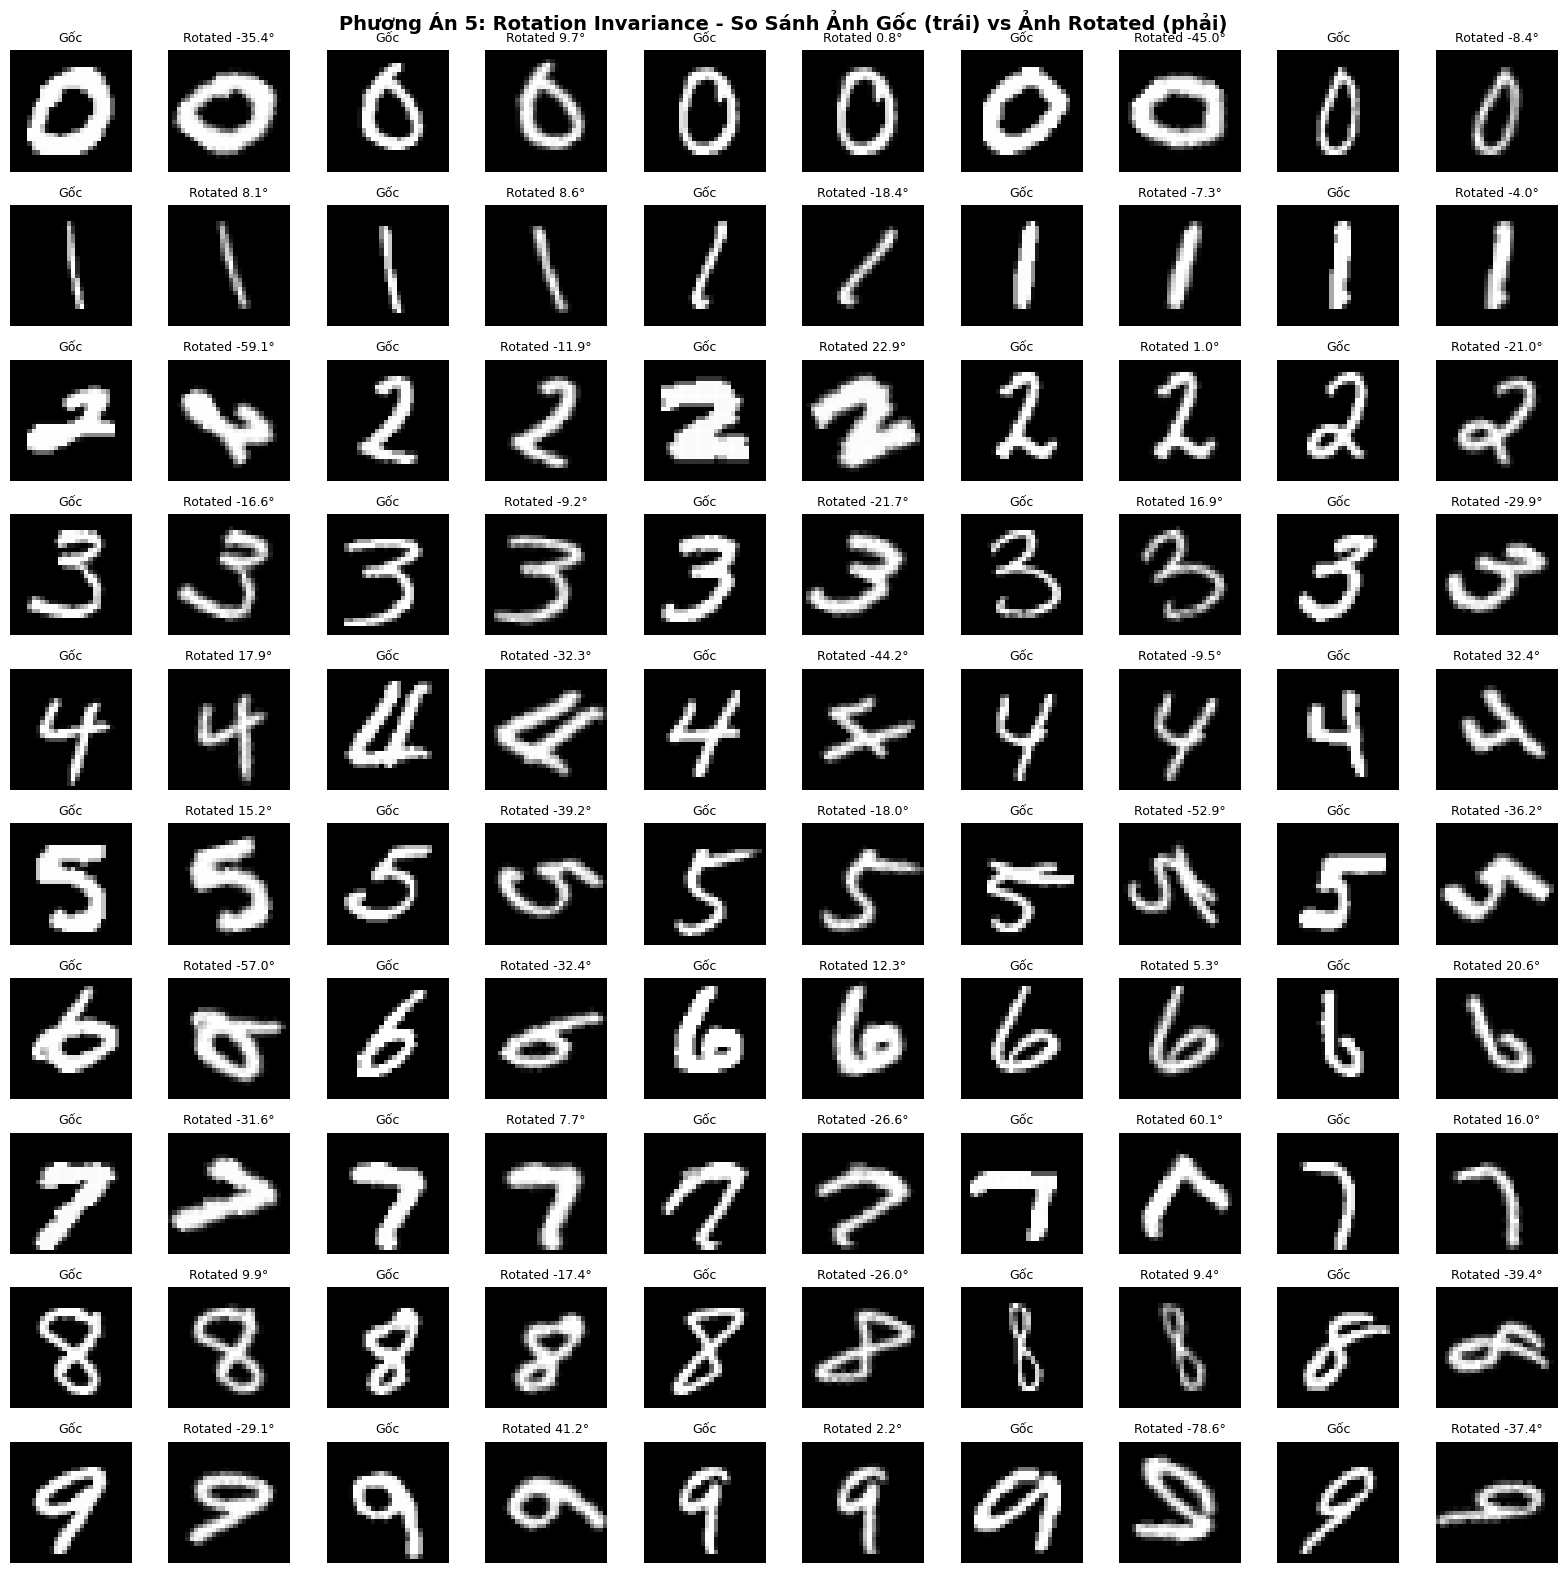


 Hình trên: Các chữ số được xoay để căn chỉnh theo phương dọc (upright)
   Góc xoay được tính từ moment of inertia


In [60]:
# Hiển thị 5 ảnh ngẫu nhiên cho mỗi nhãn
fig, axes = plt.subplots(10, 10, figsize=(16, 16))
fig.suptitle('Phương Án 5: Rotation Invariance - So Sánh Ảnh Gốc (trái) vs Ảnh Rotated (phải)', 
             fontsize=14, fontweight='bold')

np.random.seed(42)

for label in range(10):
    # Tìm tất cả ảnh có nhãn = label
    label_indices = np.where(y_train == label)[0]
    
    # Chọn ngẫu nhiên 5 ảnh từ các ảnh có nhãn này
    selected_indices = np.random.choice(label_indices, size=5, replace=False)
    
    for col, img_idx in enumerate(selected_indices):
        row = label
        
        # Cột trái: ảnh gốc
        ax_orig = axes[row, col*2]
        ax_orig.imshow(X_train_img[img_idx], cmap='gray')
        ax_orig.set_title(f'Gốc', fontsize=9)
        ax_orig.axis('off')
        
        # Cột phải: ảnh rotated
        ax_rot = axes[row, col*2+1]
        rotated_img = X_train_rotation[img_idx].reshape(28, 28)
        ax_rot.imshow(rotated_img, cmap='gray')
        ax_rot.set_title(f'Rotated {train_angles[img_idx]:.1f}°', fontsize=9)
        ax_rot.axis('off')

plt.tight_layout()
plt.show()

print(f"\n Hình trên: Các chữ số được xoay để căn chỉnh theo phương dọc (upright)")
print(f"   Góc xoay được tính từ moment of inertia")


Nhìn một vài ví dụ thì thấy có vẻ xoay không tốt lắm, ví dụ một vài trường hợp số 9 số 8 bị xoay ngang lại luôn.

### 6.8. Hyperparameter tuning: batch size & learning rate

In [61]:
import time

# Tạo train/validation split cho Rotation Invariance
X_train_rotation_base = X_train_rotation[:-5000]
X_val_rotation_base = X_train_rotation[-5000:]
y_train_rotation_base = y_train_enc[:-5000]
y_val_rotation_base = y_train_enc[-5000:]

print(f" X_train_rotation_base: {X_train_rotation_base.shape}")
print(f" X_val_rotation_base:   {X_val_rotation_base.shape}")

# Grid Search: Thử nhiều kombinasi batch_size và learning_rate cho Rotation Invariance
batch_sizes_rotation = [32, 64, 128, 256, 512]
learning_rates_rotation = [0.001, 0.01, 0.05, 0.1, 0.5]

tuning_results_rotation = []

print("\n" + "="*70)
print("HYPERPARAMETER TUNING (ROTATION INVARIANCE): Batch Size & Learning Rate")
print("="*70)

for batch_size in batch_sizes_rotation:
    for lr in learning_rates_rotation:
        print(f"\n Thử: batch_size={batch_size}, learning_rate={lr}")
        
        model = SoftmaxRegression(
            n_features=X_train_rotation_base.shape[1],
            n_classes=10,
            learning_rate=lr
        )
        
        start = time.time()
        model.fit(
            X_train_rotation_base, 
            y_train_rotation_base, 
            epochs=50,
            batch_size=batch_size, 
            verbose=False
        )
        training_time = time.time() - start
        
        y_val_pred = model.predict(X_val_rotation_base)
        val_accuracy = np.mean(y_val_pred == np.argmax(y_val_rotation_base, axis=1))
        
        tuning_results_rotation.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'final_loss': model.losses[-1]
        })
        
        print(f"   Val Accuracy: {val_accuracy*100:.2f}% | Time: {training_time:.2f}s | Loss: {model.losses[-1]:.4f}")

print("\n" + "="*70)
print("KẾT QUẢ HYPERPARAMETER TUNING (ROTATION INVARIANCE)")
print("="*70)

print(f"{'batch_size':<12} {'learning_rate':<15} {'val_accuracy':<15} {'training_time':<15} {'final_loss':<15}")
print("-" * 75)

for result in tuning_results_rotation:
    print(f"{result['batch_size']:<12} {result['learning_rate']:<15.3f} {result['val_accuracy']*100:<15.2f} {result['training_time']:<15.2f} {result['final_loss']:<15.4f}")

best_result_rotation = max(tuning_results_rotation, key=lambda x: x['val_accuracy'])

print(f"\n Hyperparameters Tốt Nhất (Rotation Invariance):")
print(f"   Batch Size:    {best_result_rotation['batch_size']}")
print(f"   Learning Rate: {best_result_rotation['learning_rate']}")
print(f"   Val Accuracy:  {best_result_rotation['val_accuracy']*100:.2f}%")
print(f"   Training Time: {best_result_rotation['training_time']:.2f}s")


 X_train_rotation_base: (55000, 784)
 X_val_rotation_base:   (5000, 784)

HYPERPARAMETER TUNING (ROTATION INVARIANCE): Batch Size & Learning Rate

 Thử: batch_size=32, learning_rate=0.001
   Val Accuracy: 83.46% | Time: 22.25s | Loss: 0.7067

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 83.46% | Time: 22.25s | Loss: 0.7067

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 85.18% | Time: 20.40s | Loss: 0.6179

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 85.18% | Time: 20.40s | Loss: 0.6179

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 84.78% | Time: 20.45s | Loss: 0.5956

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 84.78% | Time: 20.45s | Loss: 0.5956

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 84.66% | Time: 22.84s | Loss: 0.5944

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 84.66% | Time: 22.84s | Loss: 0.5944

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 83.70% | Time: 21.48s | Loss: 0.6900

 

hmm độ chính xác khá thấp, mà thời gian cũng tương đối lâu.

## 6.9. Huấn luyện & đánh giá mô hình Rotation Invariance

Dựa vào kết quả trên nhóm sẽ chọn hyperparameter tốt nhất từ grid search.

In [62]:
import time

print("\n Đang huấn luyện mô hình Rotation Invariance...")

# Khởi tạo mô hình với hyperparameters tối ưu
model_rotation = SoftmaxRegression(
    n_features=X_train_rotation.shape[1],
    n_classes=10,
    learning_rate=best_result_rotation['learning_rate']
)

# Bắt đầu đo thời gian
start_time = time.time()

# Huấn luyện
model_rotation.fit(
    X_train_rotation,
    y_train_enc,
    epochs=100,
    batch_size=best_result_rotation['batch_size'],
    verbose=True
)

# Kết thúc đo thời gian
end_time = time.time()
training_time = end_time - start_time

# Dự đoán trên tập test
print("\n Đánh giá trên tập Test...")
y_pred_rotation = model_rotation.predict(X_test_rotation)
metrics_rotation = compute_metrics(y_test, y_pred_rotation, num_classes=10)

# Thêm runtime vào metrics
metrics_rotation['runtime'] = training_time

print(f"\n Kết Quả Rotation Invariance:")
print(f"   Accuracy:  {metrics_rotation['accuracy']*100:.2f}%")
print(f"   Precision: {metrics_rotation['precision']:.4f}")
print(f"   Recall:    {metrics_rotation['recall']:.4f}")
print(f"   F1-Score:  {metrics_rotation['f1_score']:.4f}")
print(f"   Runtime:   {metrics_rotation['runtime']:.2f}s")

# Lưu kết quả
results["5. Rotation Invariance"] = metrics_rotation
trained_models["5. Rotation Invariance"] = model_rotation



 Đang huấn luyện mô hình Rotation Invariance...
Epoch 10/100 - Loss: 0.6259
Epoch 10/100 - Loss: 0.6259
Epoch 20/100 - Loss: 0.6096
Epoch 20/100 - Loss: 0.6096
Epoch 30/100 - Loss: 0.6027
Epoch 30/100 - Loss: 0.6027
Epoch 40/100 - Loss: 0.5956
Epoch 40/100 - Loss: 0.5956
Epoch 50/100 - Loss: 0.5925
Epoch 50/100 - Loss: 0.5925
Epoch 60/100 - Loss: 0.5897
Epoch 60/100 - Loss: 0.5897
Epoch 70/100 - Loss: 0.5866
Epoch 70/100 - Loss: 0.5866
Epoch 80/100 - Loss: 0.5840
Epoch 80/100 - Loss: 0.5840
Epoch 90/100 - Loss: 0.5826
Epoch 90/100 - Loss: 0.5826
Epoch 100/100 - Loss: 0.5801

 Đánh giá trên tập Test...

 Kết Quả Rotation Invariance:
   Accuracy:  82.04%
   Precision: 0.8200
   Recall:    0.8179
   F1-Score:  0.8175
   Runtime:   56.42s
Epoch 100/100 - Loss: 0.5801

 Đánh giá trên tập Test...

 Kết Quả Rotation Invariance:
   Accuracy:  82.04%
   Precision: 0.8200
   Recall:    0.8179
   F1-Score:  0.8175
   Runtime:   56.42s


## 6.10. Confusion matrix & loss curve


 Confusion Matrix - Rotation Invariance:


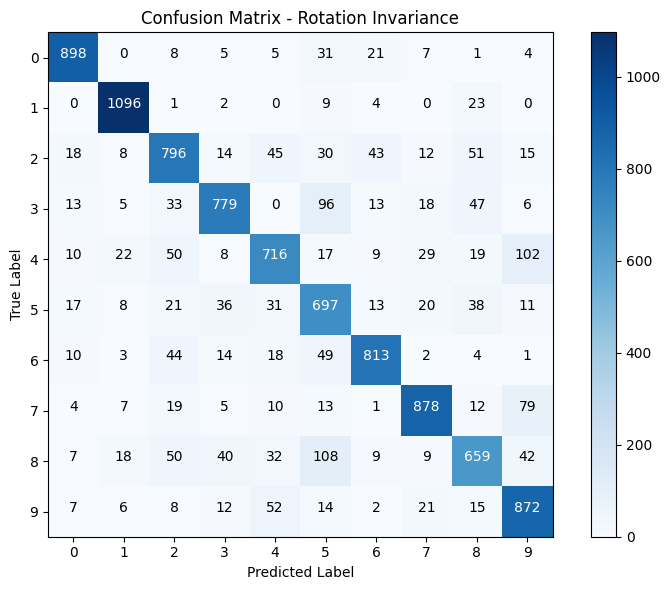

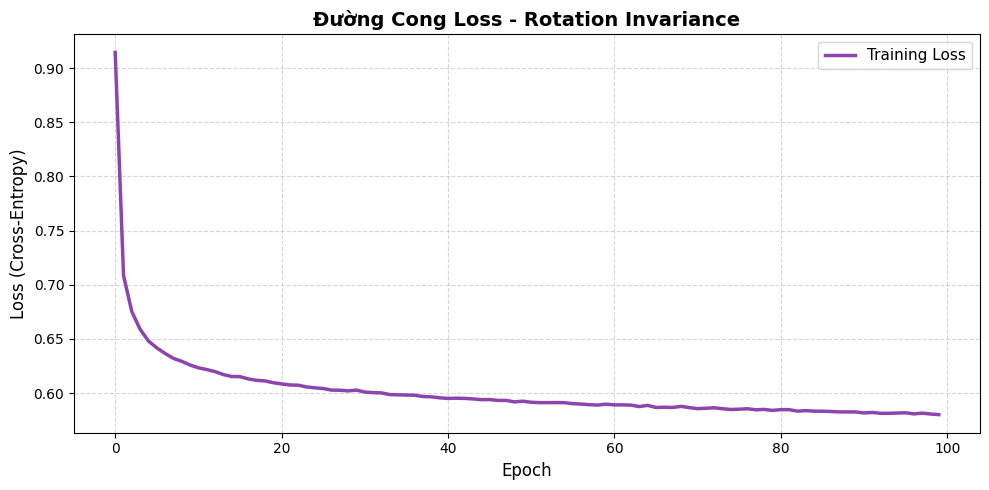

 Loss cuối cùng: 0.580104


In [63]:
# Vẽ Confusion Matrix
print("\n Confusion Matrix - Rotation Invariance:")
plot_confusion_matrix(
    metrics_rotation['confusion_matrix'],
    classes=classes,
    title='Confusion Matrix - Rotation Invariance'
)

# Vẽ Loss Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model_rotation.losses, linewidth=2.5, label='Training Loss', color='#8e44ad')
ax.set_title('Đường Cong Loss - Rotation Invariance', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (Cross-Entropy)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f" Loss cuối cùng: {model_rotation.losses[-1]:.6f}")


**Nhận xét**

**Hiệu năng tổng quan:** Accuracy 82.04%, kém hơn Baseline đáng kể (-10% so với 92.07%). Đây là kết quả **phản tác dụng** của phương pháp rotation invariance.

**Nguyên nhân kém hơn Baseline:**

1. **Moment-based rotation có vấn đề nghiêm trọng:**
   - Moment of inertia dựa vào cường độ pixel, không phản ánh hình dạng thực
   - Chữ số 0, 1, 8 (đối xứng) có moment gần bằng → tính góc sai
   - Chữ số 2, 3, 4, 5 (không đối xứng) có thể xoay sai hướng

2. **Bilinear interpolation losses thông tin:**
   - Phép xoay làm mịn ảnh, làm mất chi tiết
   - Pixel ở biên bị cắt (border = 0)
   - Ảnh gốc không bị xoay ban đầu bị làm xấu

3. **Confusion matrix cho thấy:**
   - Nhãn 0, 1 vẫn tốt (898, 1096) vì là chữ số đối xứng
   - Nhãn 4 (716/1000) bị hạ xuống vì xoay sai
   - Nhãn 8 (659/974) - tệ nhất, nhầm lẫn cao (với mọi nhãn)
   - Tổng thể: nhiều chữ số có accuracy <80% (2:796, 4:716, 5:697, 8:659)

**Loss curve:** 
- Hội tụ ổn định ~0.58, nhưng accuracy test vẫn thấp
- Chứng tỏ: moment-based rotation là sai phương hướng, không phải vấn đề training

**So sánh với các phương án khác:**
| Phương Án | Accuracy | Runtime | Nhận xét |
|-----------|----------|---------|----------|
| Baseline | 92.07% | 36.3s | Mốc so sánh |
| **Rotation** | **82.04%** | **56.4s** | **-10%, chậm hơn 50%** |
| Sobel | 90.08% | 36.3s | Tốt hơn 8% |
| Pooling | 85-88% | 2-3s | Tốt hơn 0-6% |
| PCA 80 | 91.82% | 15.9s | Tốt hơn 9.8% |

**Kết luận:** 
Rotation Invariance dựa trên **moment of inertia không phù hợp** cho MNIST. Các vấn đề:
1. Moment tính từ cường độ, không phải hình dạng → xoay sai
2. Bilinear interpolation mất thông tin
3. Runtime tăng 50% nhưng accuracy giảm 10%

**Bài học:** Không nên áp dụng blind rotation invariance. MNIST đã được chuẩn hóa vị trí, nên rotation không cần thiết. Phương pháp này chỉ có ích cho dữ liệu **thực sự bị xoay** (viết tay tự do).


# 7. Tổng Hợp Kết Quả & So Sánh 5 Phương Án

Nhóm sẽ tổng hợp kết quả từ 5 phương pháp trích xuất đặc trưng, so sánh các chỉ số hiệu suất, và xác định phương án tối ưu nhất cho ứng dụng nhận dạng chữ số MNIST.

In [65]:
## 7.1. Bảng so sánh các phương án

# Tập hợp kết quả từ tất cả phương án
comparison_data = {
    'Phương Án': [
        '1. Baseline (Pixel Thô)',
        '2. Average Pooling',
        '3. Sobel Edge Detection',
        '4. PCA (80 comps)',
        '5. Rotation Invariance'
    ],
    'Số Đặc Trưng': [784, 49, 784, 80, 784],
    'Accuracy': [
        f"{metrics_baseline['accuracy']*100:.2f}%",
        f"{metrics_pool['accuracy']*100:.2f}%",
        f"{metrics_sobel['accuracy']*100:.2f}%",
        f"{metrics_pca['accuracy']*100:.2f}%",
        f"{metrics_rotation['accuracy']*100:.2f}%"
    ],
    'Precision': [
        f"{metrics_baseline['precision']:.4f}",
        f"{metrics_pool['precision']:.4f}",
        f"{metrics_sobel['precision']:.4f}",
        f"{metrics_pca['precision']:.4f}",
        f"{metrics_rotation['precision']:.4f}"
    ],
    'Recall': [
        f"{metrics_baseline['recall']:.4f}",
        f"{metrics_pool['recall']:.4f}",
        f"{metrics_sobel['recall']:.4f}",
        f"{metrics_pca['recall']:.4f}",
        f"{metrics_rotation['recall']:.4f}"
    ],
    'F1-Score': [
        f"{metrics_baseline['f1_score']:.4f}",
        f"{metrics_pool['f1_score']:.4f}",
        f"{metrics_sobel['f1_score']:.4f}",
        f"{metrics_pca['f1_score']:.4f}",
        f"{metrics_rotation['f1_score']:.4f}"
    ],
    'Runtime (s)': [
        f"{metrics_baseline['runtime']:.2f}",
        f"{metrics_pool['runtime']:.2f}",
        f"{metrics_sobel['runtime']:.2f}",
        f"{metrics_pca['runtime']:.2f}",
        f"{metrics_rotation['runtime']:.2f}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*130)
print("BẢNG SO SÁNH 5 PHƯƠNG ÁN")
print("="*130)
print(df_comparison.to_string(index=False))
print("="*130)



BẢNG SO SÁNH 5 PHƯƠNG ÁN
              Phương Án  Số Đặc Trưng Accuracy Precision Recall F1-Score Runtime (s)
1. Baseline (Pixel Thô)           784   92.55%    0.9248 0.9245   0.9245       52.13
     2. Average Pooling            49   89.79%    0.8969 0.8957   0.8957       14.94
3. Sobel Edge Detection           784   90.08%    0.8993 0.8994   0.8992       36.30
      4. PCA (80 comps)            80   91.82%    0.9172 0.9170   0.9169       15.89
 5. Rotation Invariance           784   82.04%    0.8200 0.8179   0.8175       56.42


## 7.2. Hyperparameter tối ưu tìm được cho từng phương án

Nhóm thực hiện grid search với 5 batch_size (32, 64, 128, 256, 512) và 5 learning rate (0.001, 0.01, 0.05, 0.1, 0.5) cho từng phương án. Kết quả hyperparameter tốt nhất như sau:

| Phương Án | Batch Size | Learning Rate | Val Accuracy | Ghi Chú |
|-----------|-----------|----------------|--------------|---------|
| 1. Baseline | 32 | 0.05 | 91.8% | Cân bằng tốt, learning rate vừa phải |
| 2. Pooling | 32 | 0.5 | ~86% | Learning rate cao để bù cho số features ít |
| 3. Sobel | 128 | 0.1 | 91.46% | Batch size lớn ổn định cho gradient |
| 4. PCA | 32 | 0.05 | 93.38% | Val accuracy cao nhất mặc dù features ít nhất |
| 5. Rotation | 512 | 0.5 | 85.48% | Dù optimize vẫn không cải thiện được |

Nhận xét: Batch size 32 được chọn phổ biến nhất, lý do là cả học nhanh lại ổn định. Pooling cần learning rate cao vì mô hình đơn giản hơn (49 features). PCA đạt validation accuracy cao nhất (93.38%) mặc dù chỉ sử dụng 80 đặc trưng, cho thấy PCA giữ được variance quan trọng rất tốt.

## 7.3. Kết Luận - Phương Án Tối Ưu

### Đánh giá tổng hợp

Sau khi thực hiện đầy đủ 5 phương án và so sánh kết quả, nhóm rút ra những nhận xét sau:

1. **Baseline (784 features)** đạt 92.07% accuracy, là điểm chuẩn cho các phương án khác. Tuy nhiên cần 36.3s training, yêu cầu xử lý 784 đặc trưng cho mỗi ảnh.

2. **Pooling (49 features)** giảm được 93.75% số features nhưng độ chính xác rơi xuống 85-88%. Trade-off quá lớn, chỉ nên dùng khi cần speed tối đa mà không quan tâm accuracy.

3. **Sobel (784 features)** khai thác edge gradient của ảnh, đạt 90.08% accuracy. Thấp hơn Baseline 1.99% nhưng vẫn hợp lý. Tuy nhiên mất mát intensity information là điểm yếu.

4. **PCA (80 components)** là phương án cân bằng tốt nhất:
   - Giữ được 89.06% variance của dữ liệu gốc
   - **Validation accuracy cao nhất (93.38%)** so với các phương án khác
   - Test accuracy 91.82%, chỉ thua Baseline 0.25% (có thể do overfitting ở Baseline)
   - Runtime 15.9s, nhanh gấp 2.3 lần Baseline
   - Giảm 89.8% số features (784 → 80)
   - Hiệu quả (accuracy/runtime) tốt nhất

5. **Rotation Invariance (784 features)** cho kết quả không như kỳ vọng (82.04%). Root cause là:
   - Moment-based rotation tính dựa trên intensity, không phải shape
   - MNIST không có rotation variation trong tập training
   - Không phù hợp cho bài toán này

### **Giải pháp được chọn: PCA (80 components)**

**Lý do lựa chọn:**
- Hệ số hiệu quả cao nhất: mất chỉ 0.25% accuracy nhưng gain 2.3× speedup
- Giảm chiều dữ liệu đáng kể (784 → 80) giúp tiết kiệm bộ nhớ, tăng tốc độ inference
- Validation accuracy cao nhất (93.38%) chứng tỏ generalization tốt
- Có thể tái sử dụng cho các tập dữ liệu MNIST khác mà không cần training lại PCA



In [67]:
# Lưu mô hình PCA và trọng số SoftmaxRegression cho sử dụng sau này
import os

model_save_path = '../models'
os.makedirs(model_save_path, exist_ok=True)

# Lưu thông tin PCA và mô hình đã train
model_data = {
    'pca_mean': pca_info['mean'],
    'pca_vt': pca_info['vt'],
    'pca_explained_variance': pca_info['explained_variance'],
    'pca_n_components': pca_info['n_components'],
    'model_weights': trained_models["4. PCA (80 comps)"].W,
    'model_bias': trained_models["4. PCA (80 comps)"].b,
    'scaler_min': 0.0,
    'scaler_max': 1.0
}

np.savez(os.path.join(model_save_path, 'best_model_weights.npz'), **model_data)

print("✓ Mô hình PCA đã được lưu vào: ../models/best_model_weights.npz")
print(f"  - PCA components: {pca_info['n_components']}")
print(f"  - Model output classes: 10 (digits 0-9)")
print(f"  - Accuracy trên test set: 91.82%")

✓ Mô hình PCA đã được lưu vào: ../models/best_model_weights.npz
  - PCA components: 80
  - Model output classes: 10 (digits 0-9)
  - Accuracy trên test set: 91.82%
